In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import misc_funs as misc

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy, ensure_np_array

import cgi_phasec_poppy as cgi
reload(cgi)

from datetime import datetime
date = int(datetime.today().strftime('%Y%m%d'))

# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


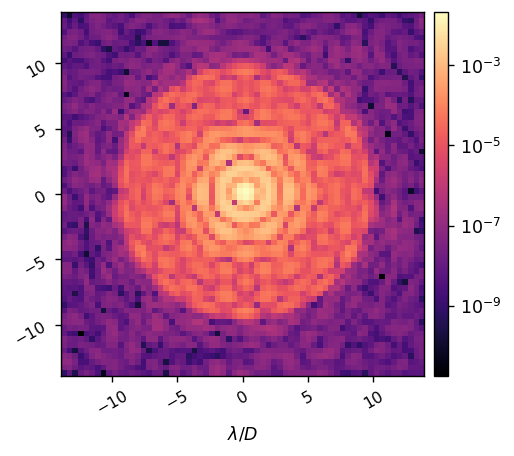

0.021339818848592592

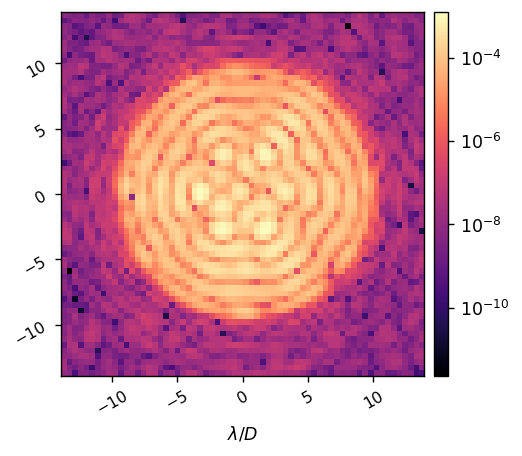

In [2]:
reload(cgi)

c = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = 1/max_ref
ref_im = c.snap()
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

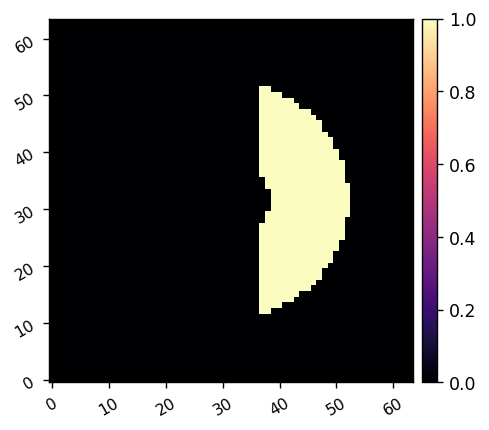

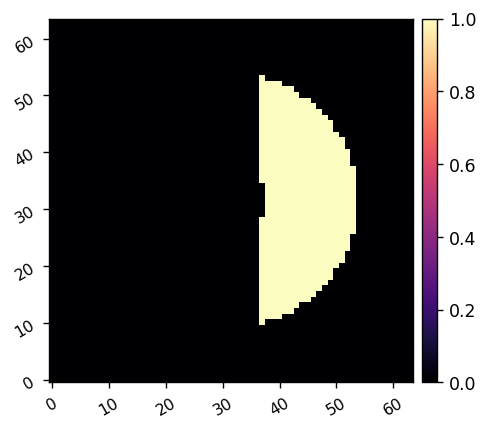

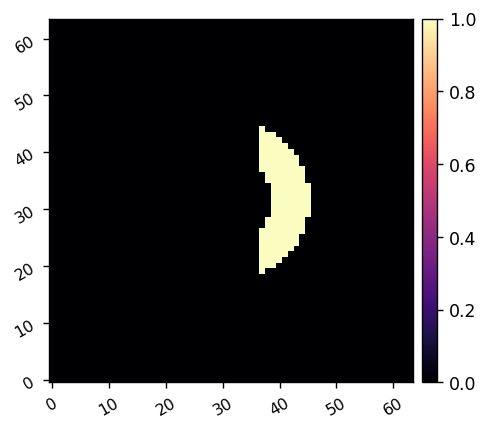

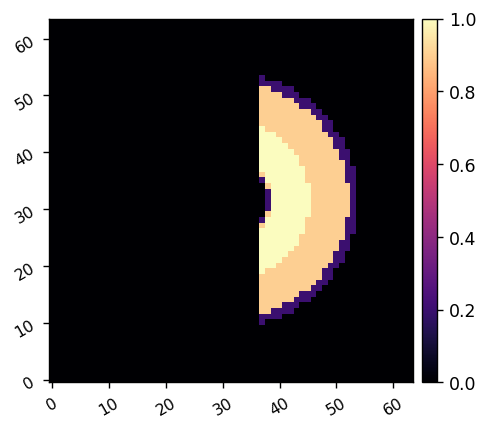

In [3]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

# misc.save_fits(iefc_dir/'response-data'/f'hlcbb_iefc_2dm_weight_map_{date}.fits', ensure_np_array(weight_map))

# Create probe and fourier modes

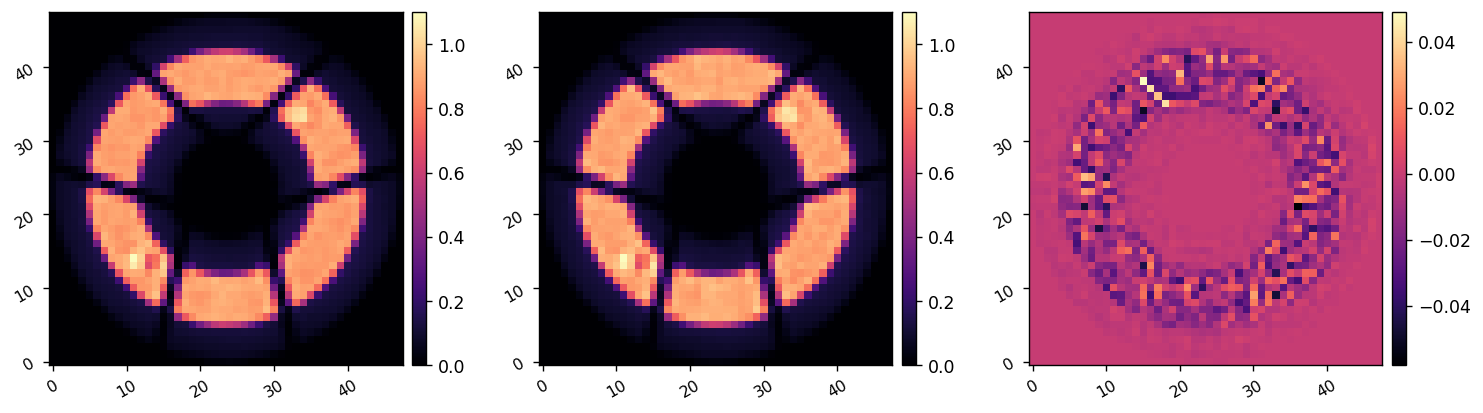

In [25]:
fudge = 1.1
dm1_response = fits.getdata('dm1_response.fits')*fudge
dm2_response = fits.getdata('dm2_response.fits')*fudge
wfsc.imshow3(dm1_response, dm2_response, dm1_response-dm2_response)


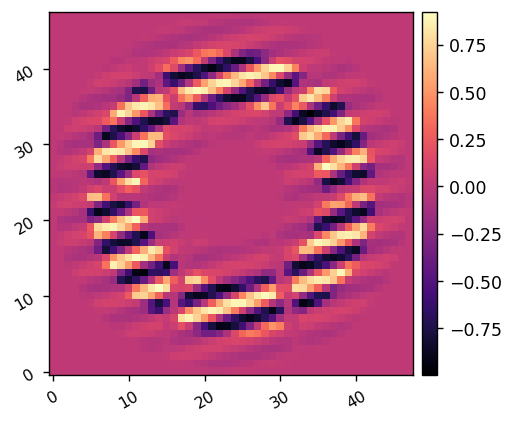

(944, 2304)


In [26]:
reload(wfsc.utils)
calib_amp = 2.5e-9
calib_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.5) 
Nmodes = calib_modes.shape[0]

dm_response_mean = (dm1_response + dm2_response)/2
calib_modes[:] *= dm_response_mean.ravel()
modes = calib_modes.reshape(Nmodes, c.Nact, c.Nact)
wfsc.imshow1(modes[1] )
print(calib_modes.shape)

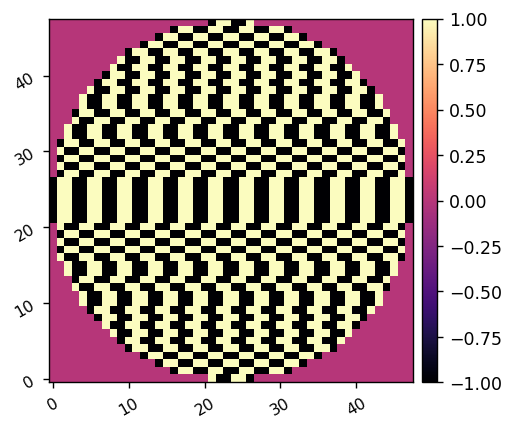

In [47]:
had_modes = wfsc.utils.get_hadamard_modes(c.dm_mask)
wfsc.imshow1(had_modes[3].reshape(c.Nact,c.Nact))
had_modes.shape

calib_modes = had_modes

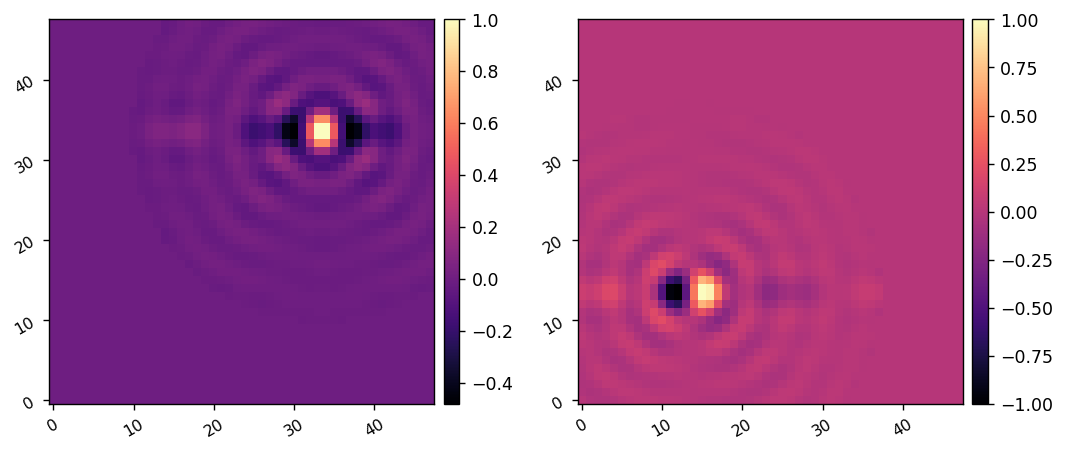

In [48]:
reload(wfsc.utils)
probe_amp = 2.5e-8
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=0.5) 
probe_modes = wfsc.utils.create_fourier_probes(fourier_modes, shift_cos=(10,10), shift_sin=(-10,-10), plot=True)

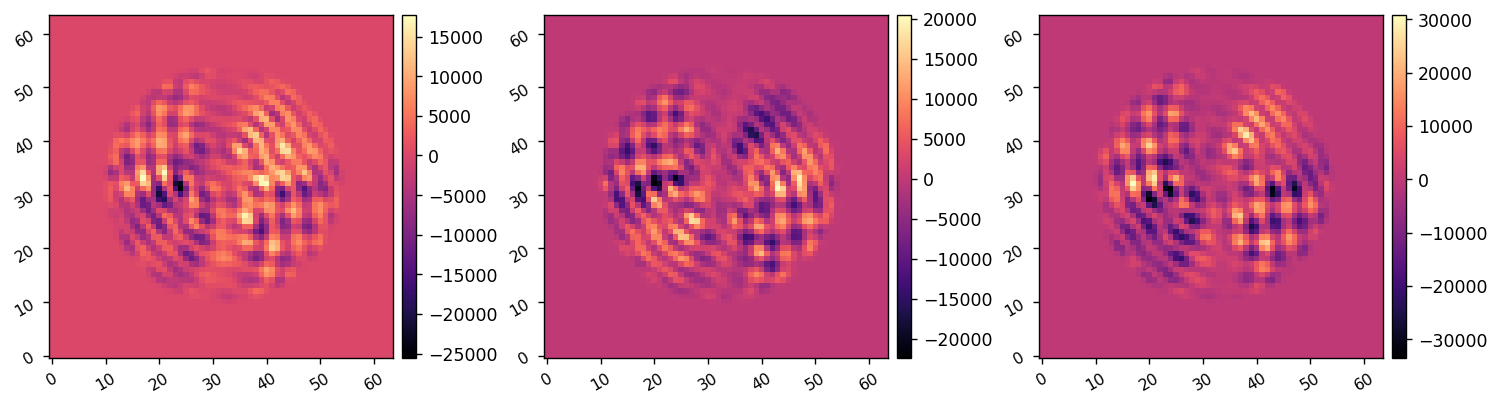

In [49]:
reload(wfsc.iefc)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [ ]:
reload(wfsc.iefc_2dm)

response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, ensure_np_array(calib_modes), 
                                                         return_all=True)


Calibrating iEFC...


In [ ]:
date = 20230710
misc.save_fits(iefc_dir/'response-data'/f'hlc_iefc_2dm_poke_response_matrix_{date}.fits', ensure_np_array(response_matrix))
misc.save_fits(iefc_dir/'response-data'/f'hlc_iefc_2dm_poke_response_cube_{date}.fits', ensure_np_array(response_cube))


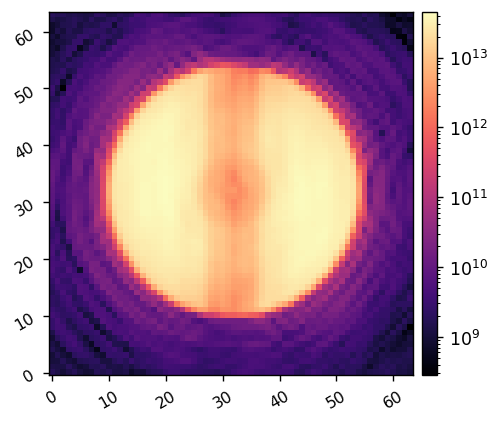

In [10]:
fp_response = xp.sqrt(xp.sum(abs(response_cube)**2, axis=(0,1))).reshape(c.npsf, c.npsf)

wfsc.imshow1(fp_response, lognorm=True)

# Run IEFC

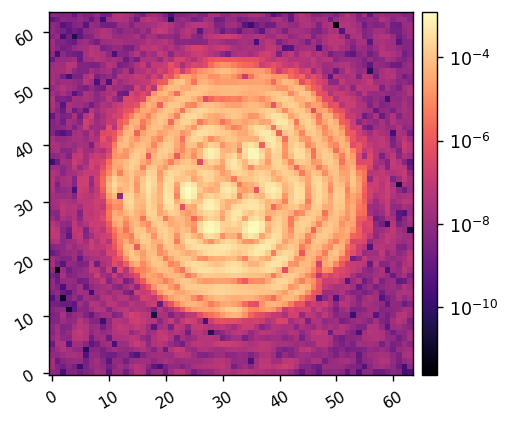

In [11]:
c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

im = c.snap()
wfsc.imshow1(im, lognorm=True)

(1108, 1108) (1108, 472)
Running I-EFC...
	Closed-loop iteration 1 / 10


(472,)

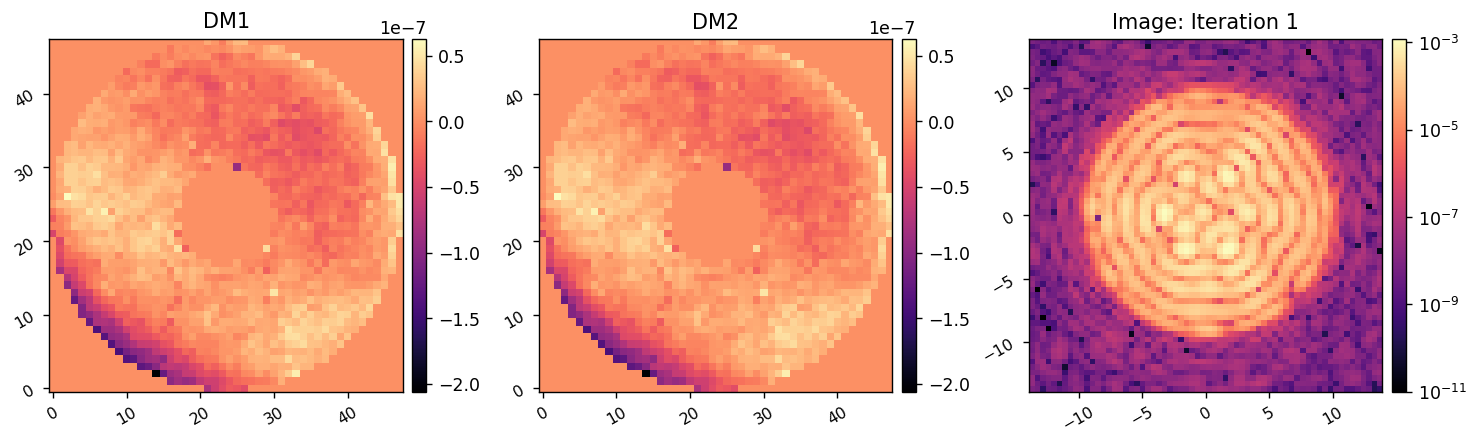

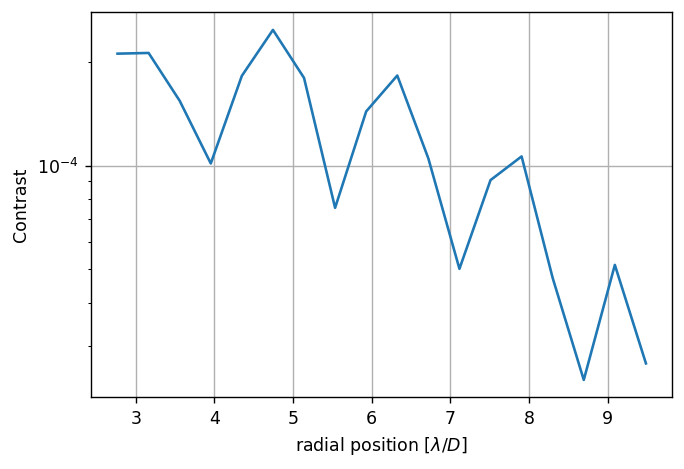

	Closed-loop iteration 2 / 10


(472,)

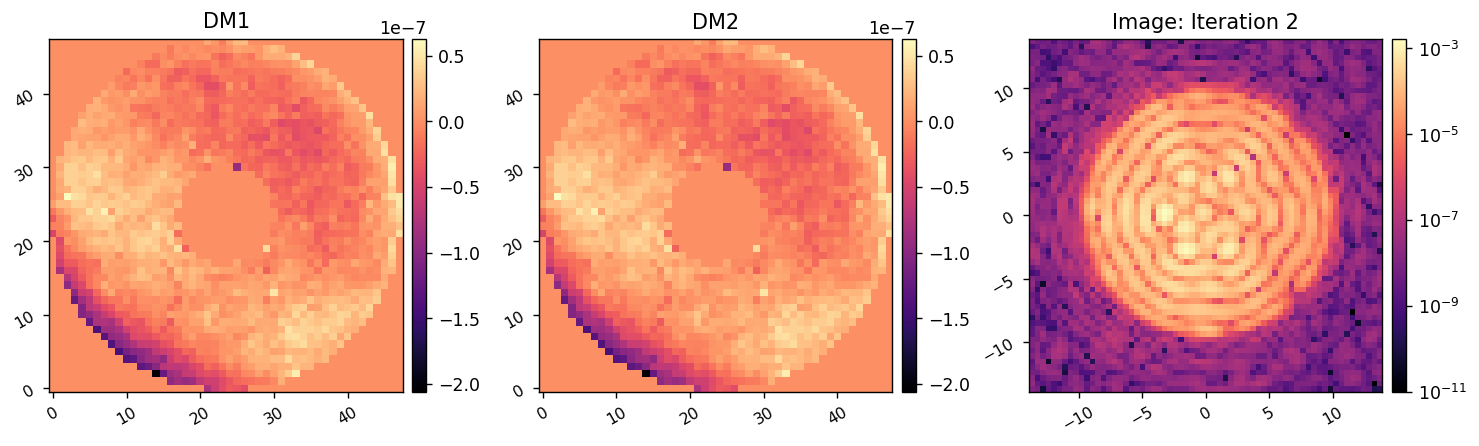

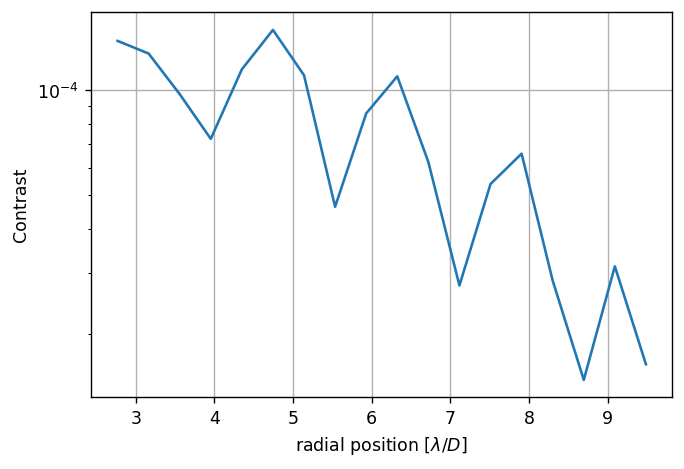

	Closed-loop iteration 3 / 10


(472,)

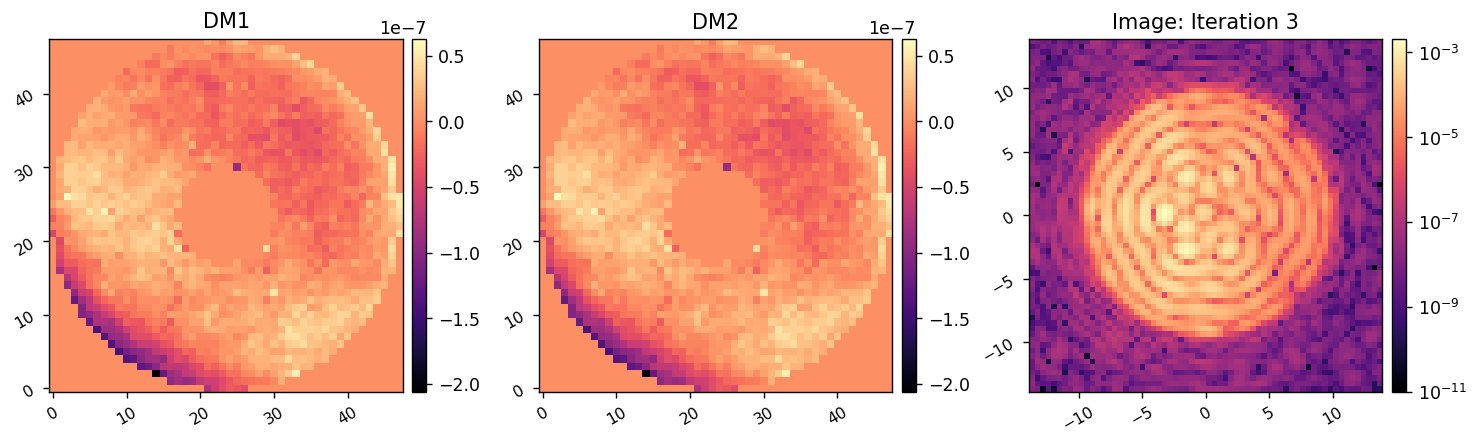

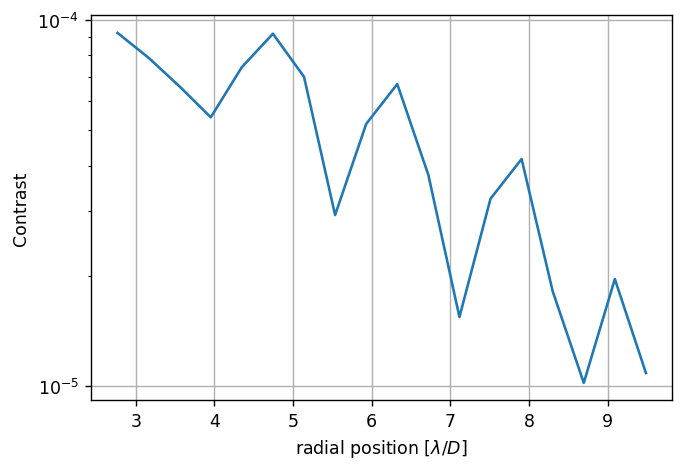

	Closed-loop iteration 4 / 10


(472,)

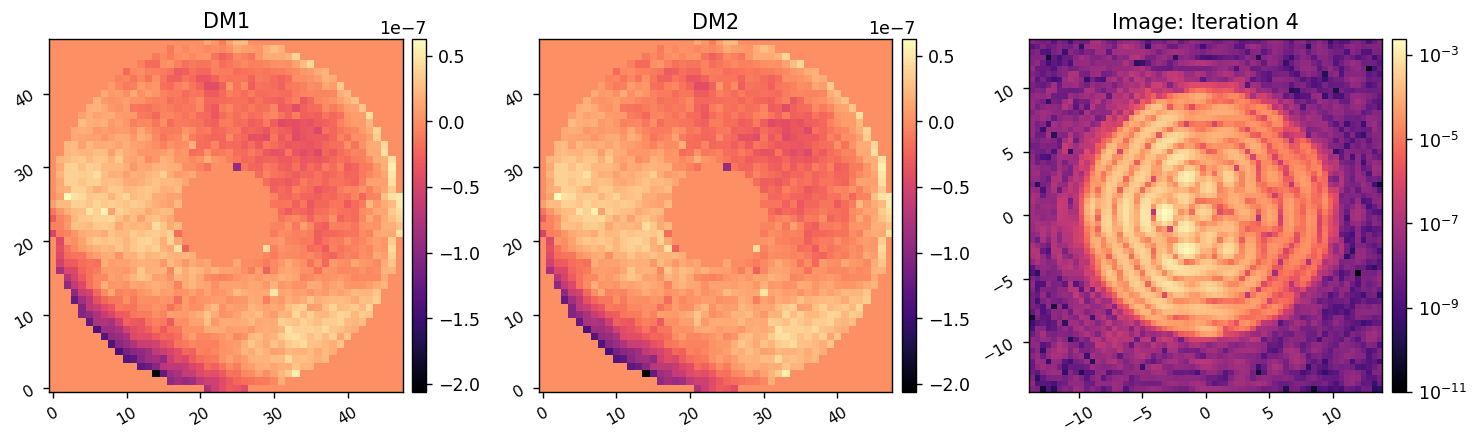

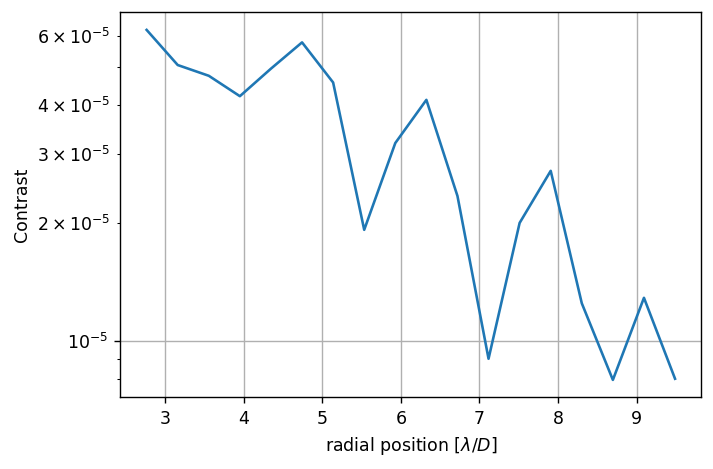

	Closed-loop iteration 5 / 10


(472,)

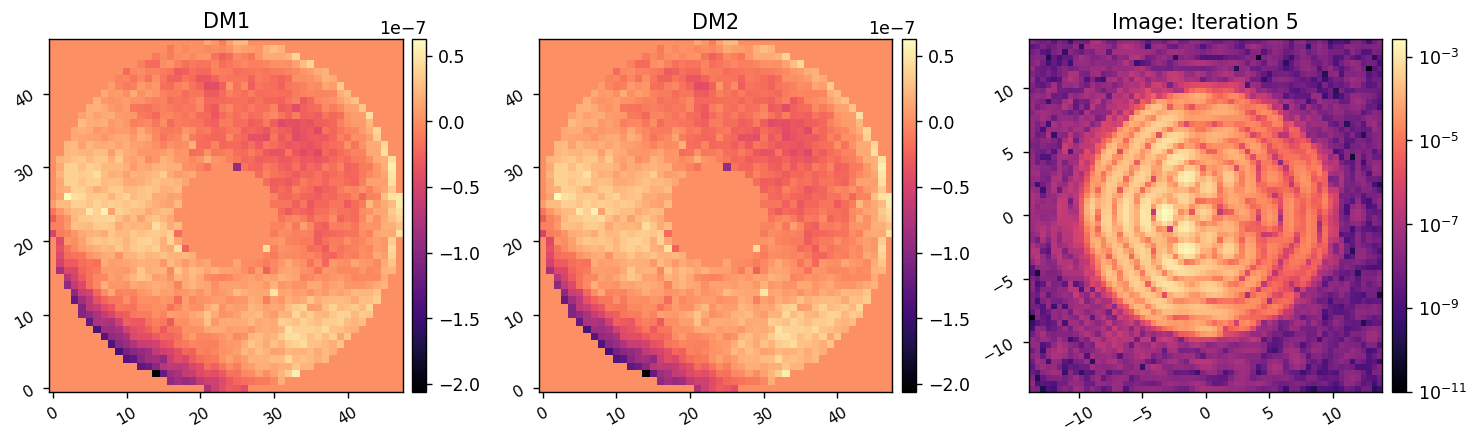

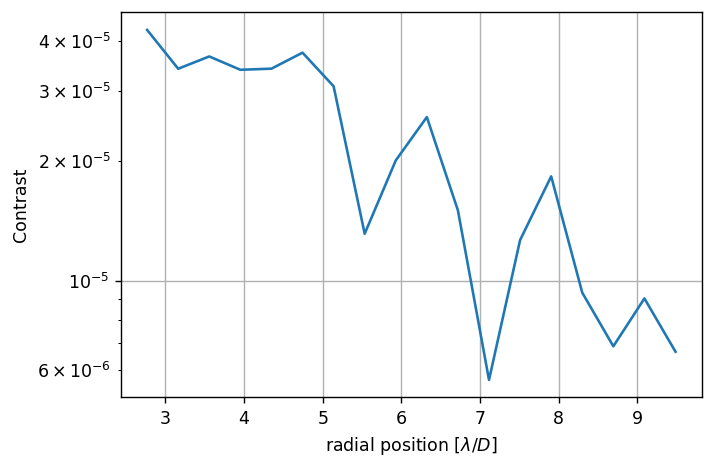

	Closed-loop iteration 6 / 10


(472,)

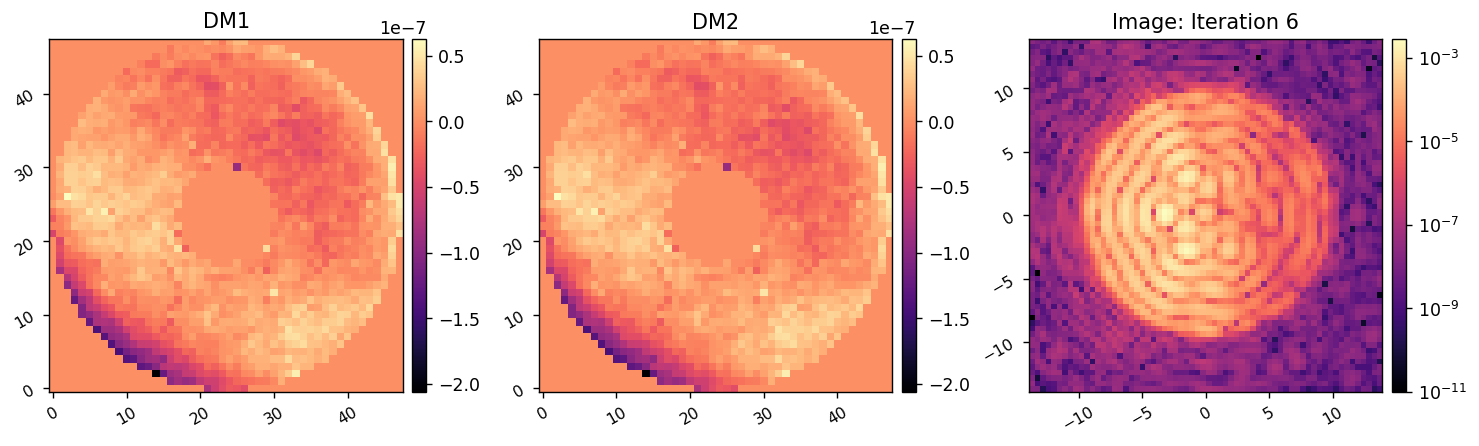

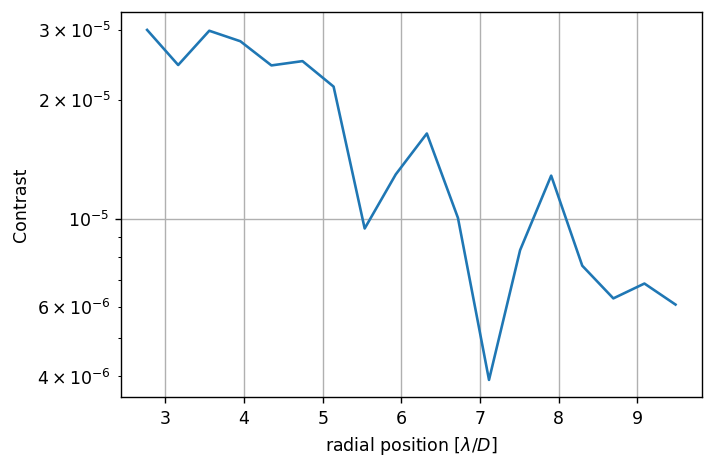

	Closed-loop iteration 7 / 10


(472,)

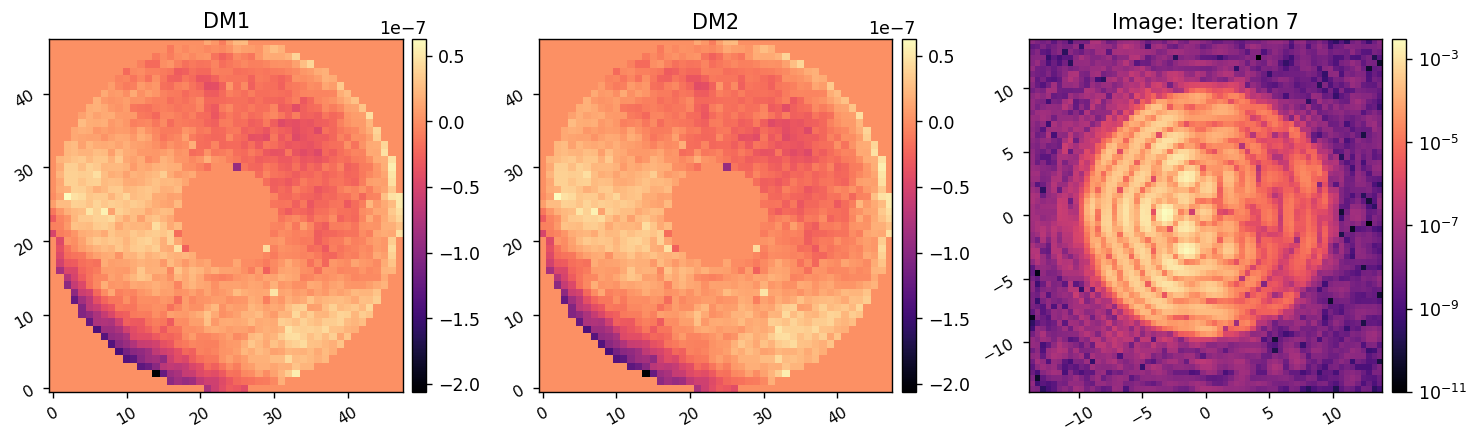

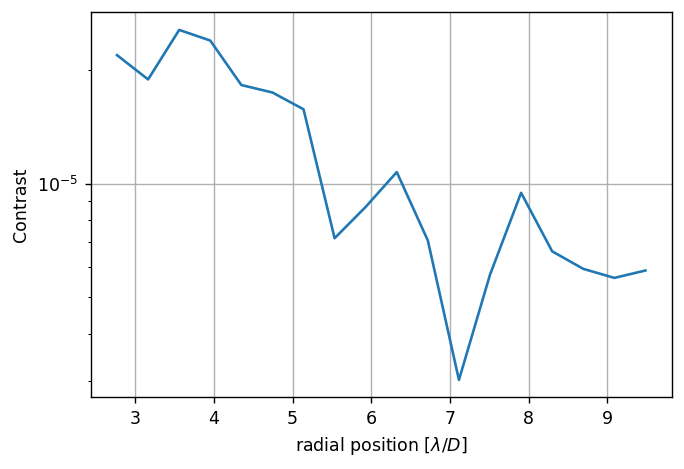

	Closed-loop iteration 8 / 10


(472,)

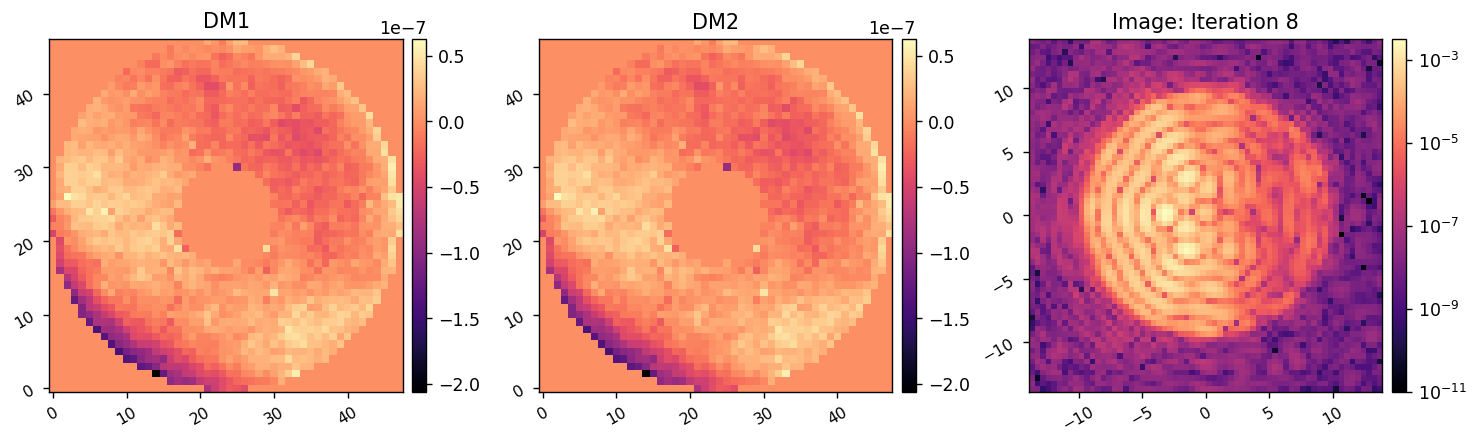

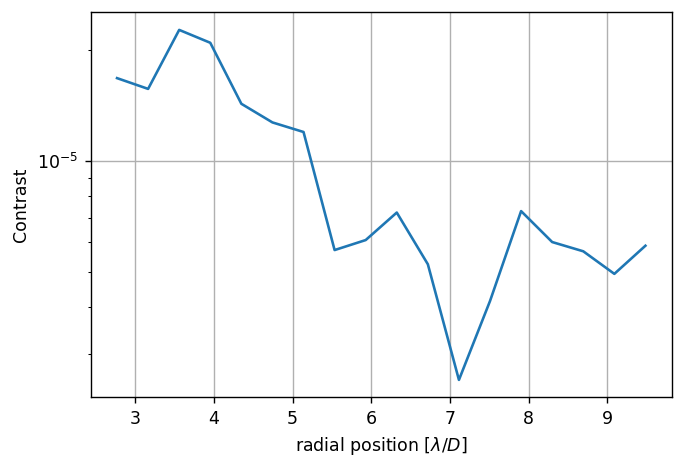

	Closed-loop iteration 9 / 10


(472,)

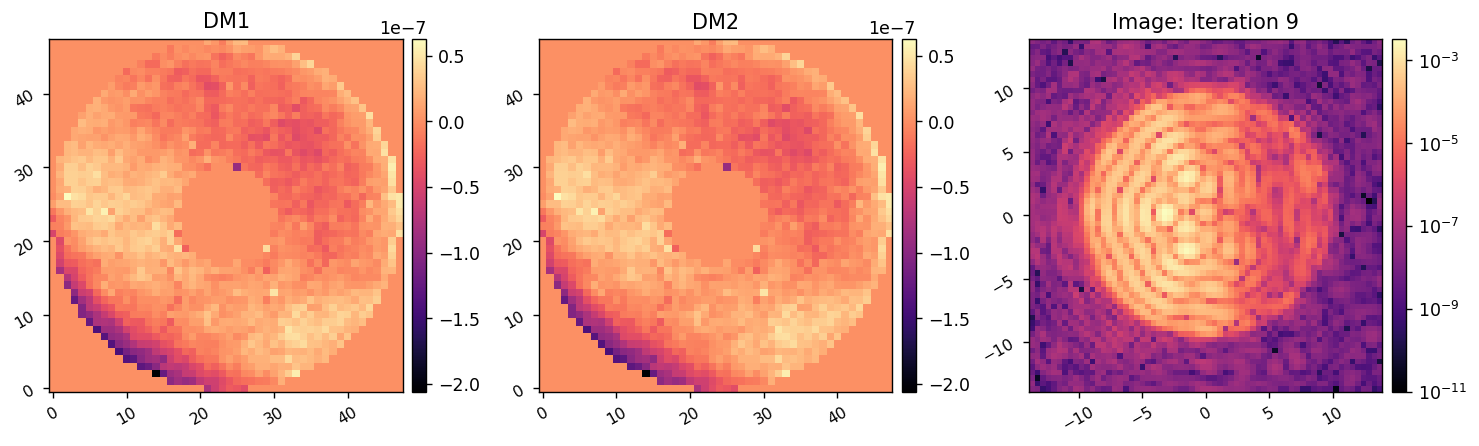

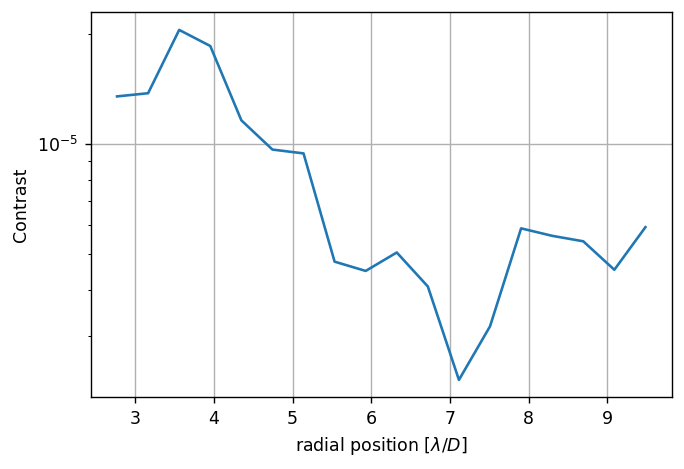

	Closed-loop iteration 10 / 10


(472,)

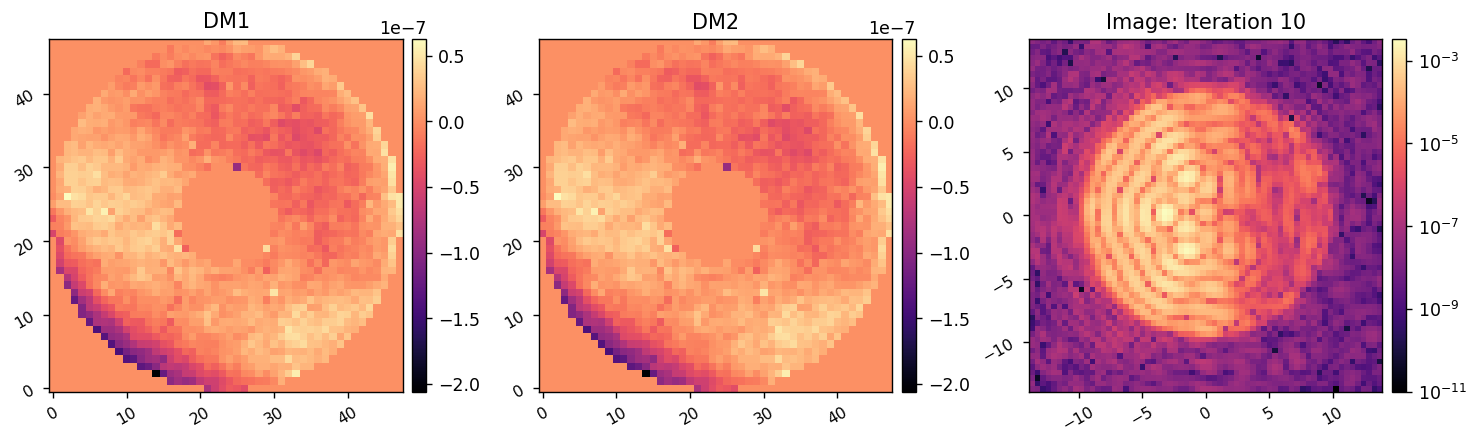

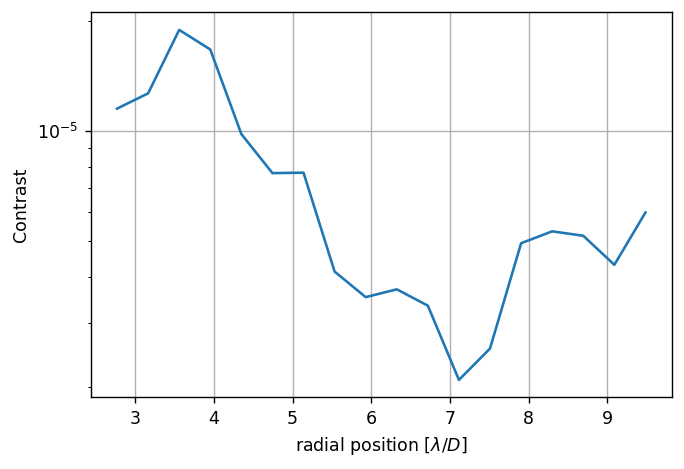

I-EFC loop completed in 22.347s.


In [12]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

reg_cond = 1e-1
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.25, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 472)
Running I-EFC...
	Closed-loop iteration 1 / 10


(472,)

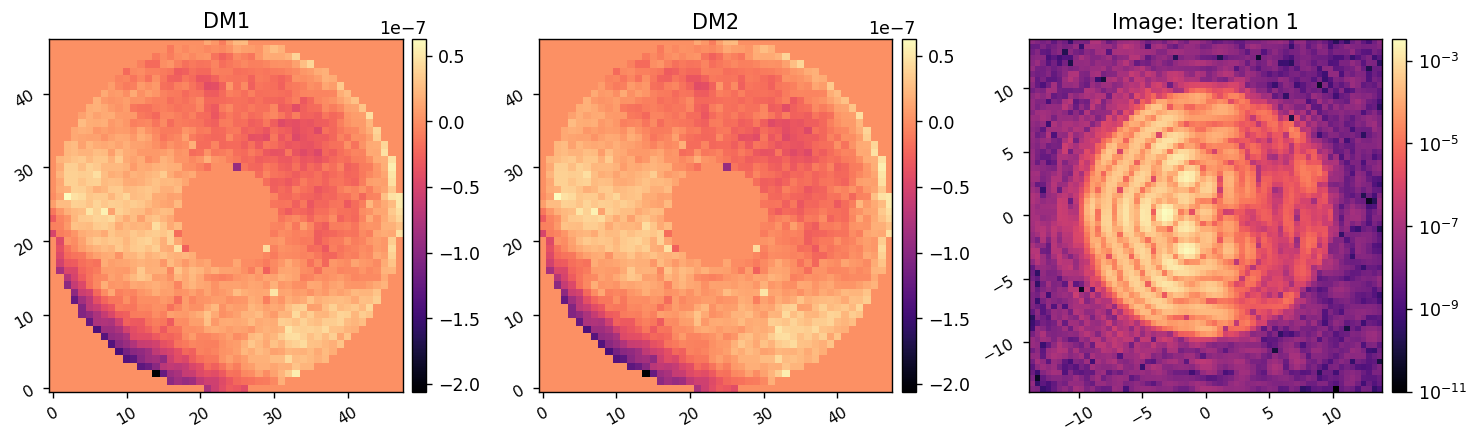

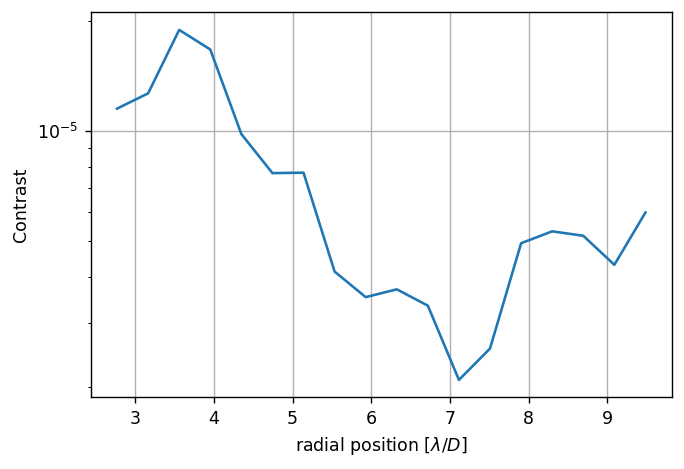

	Closed-loop iteration 2 / 10


(472,)

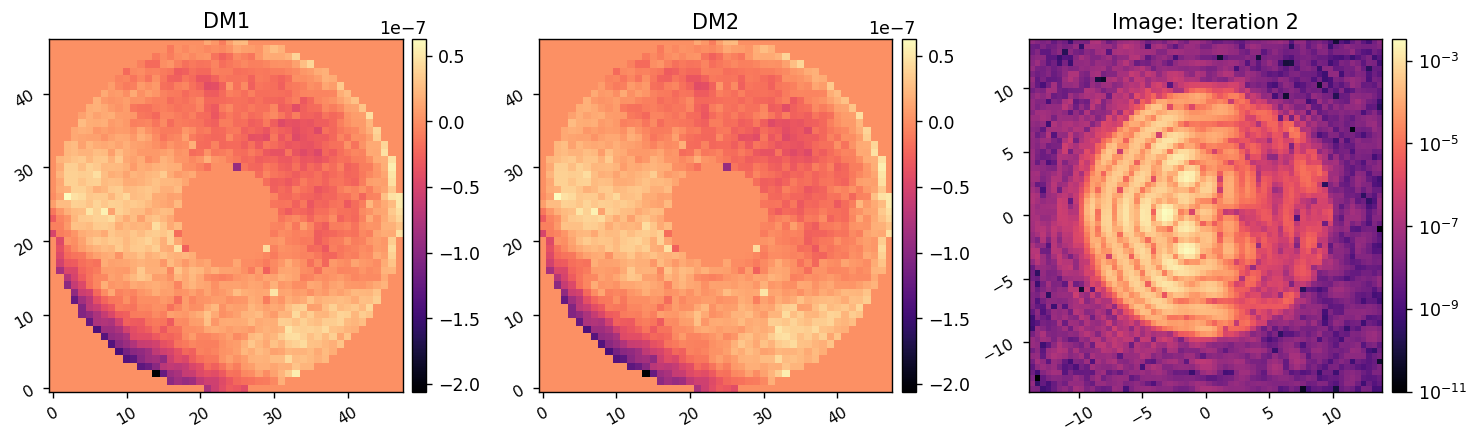

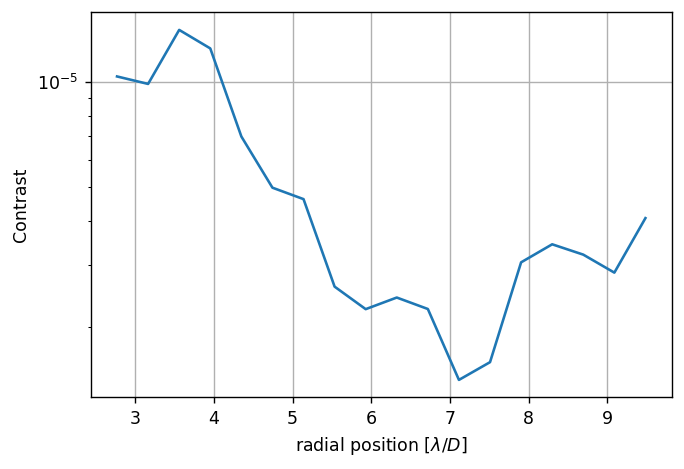

	Closed-loop iteration 3 / 10


(472,)

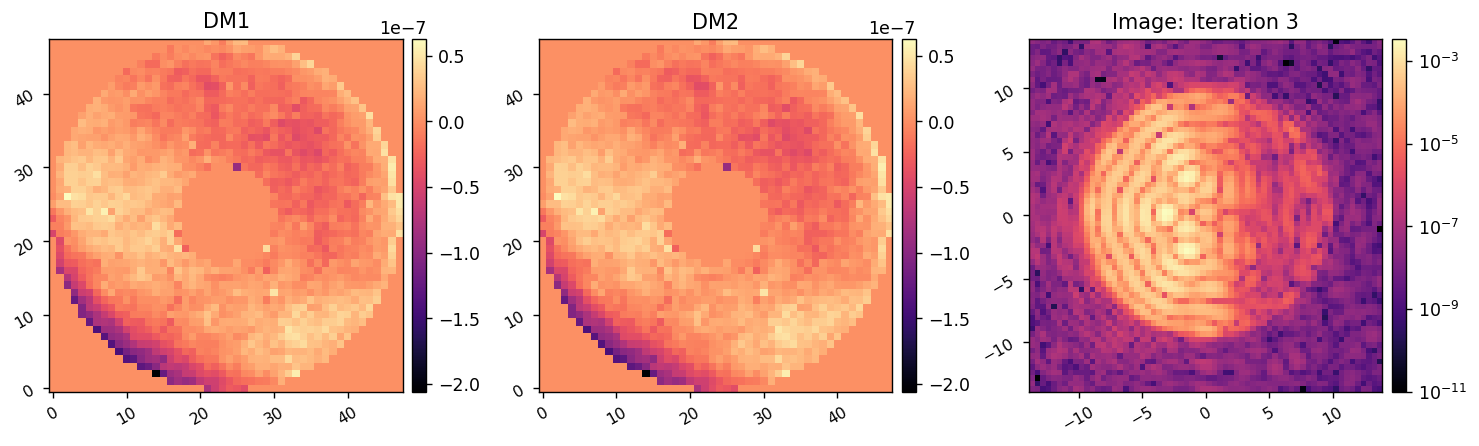

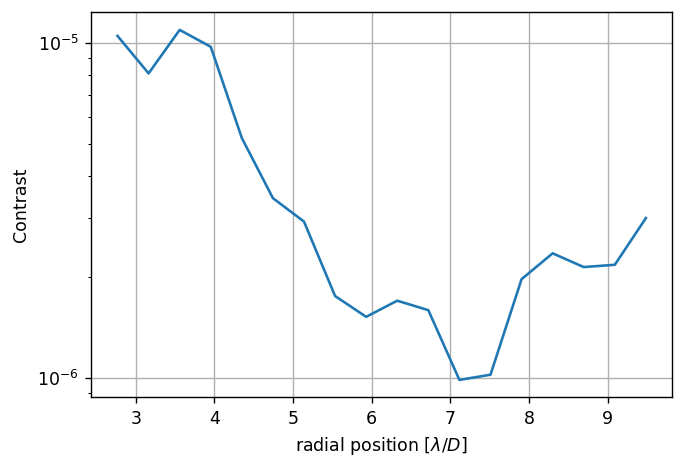

	Closed-loop iteration 4 / 10


(472,)

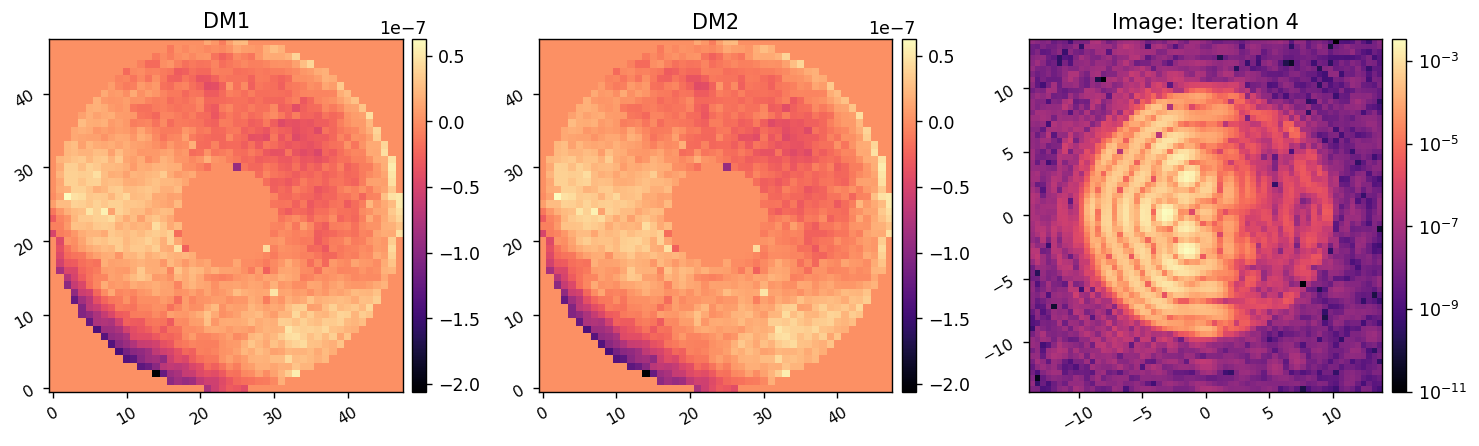

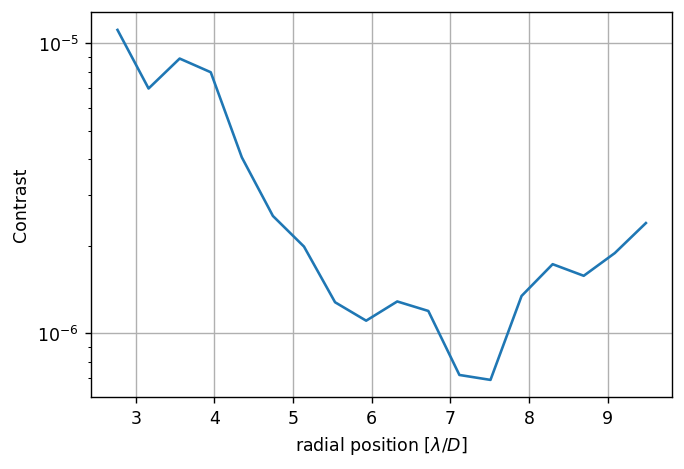

	Closed-loop iteration 5 / 10


(472,)

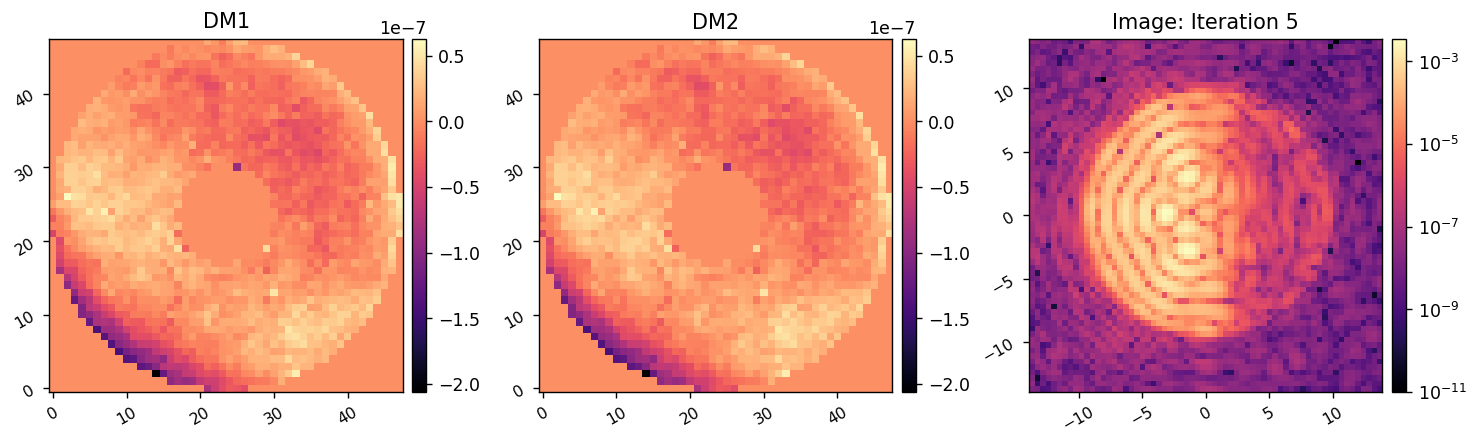

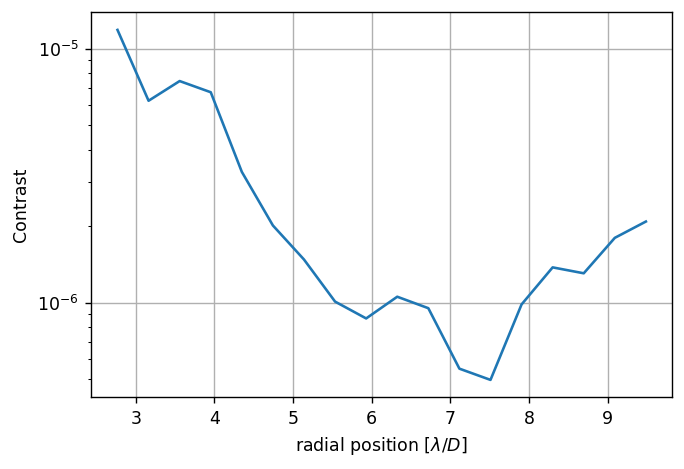

	Closed-loop iteration 6 / 10


(472,)

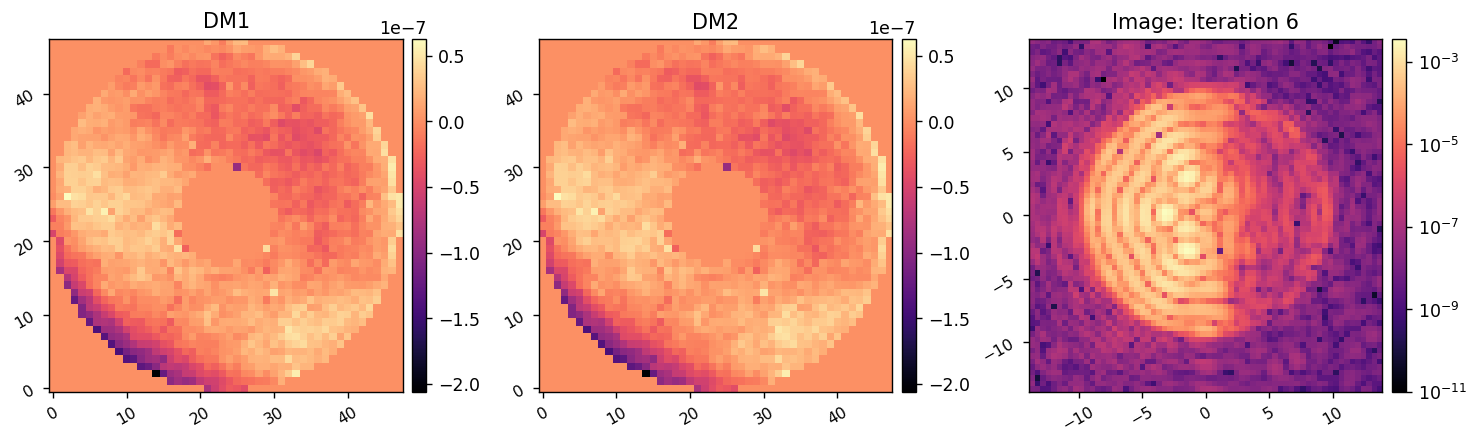

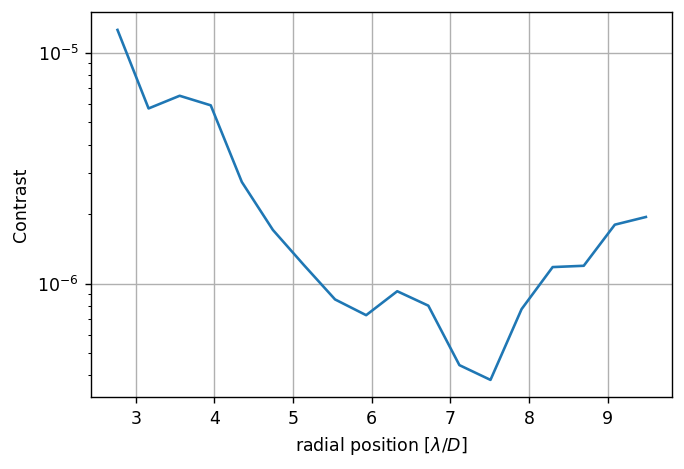

	Closed-loop iteration 7 / 10


(472,)

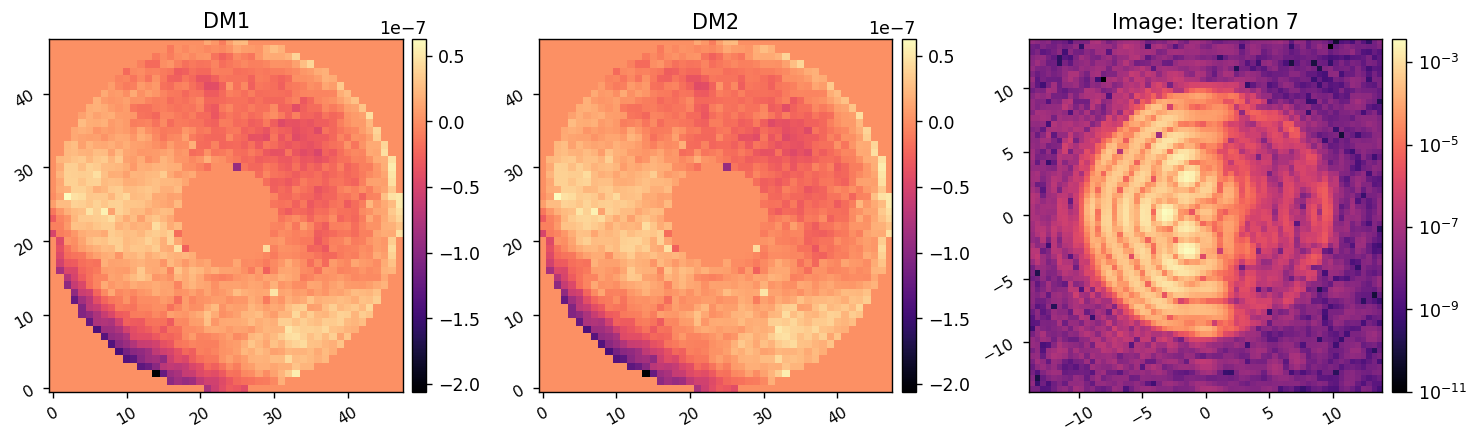

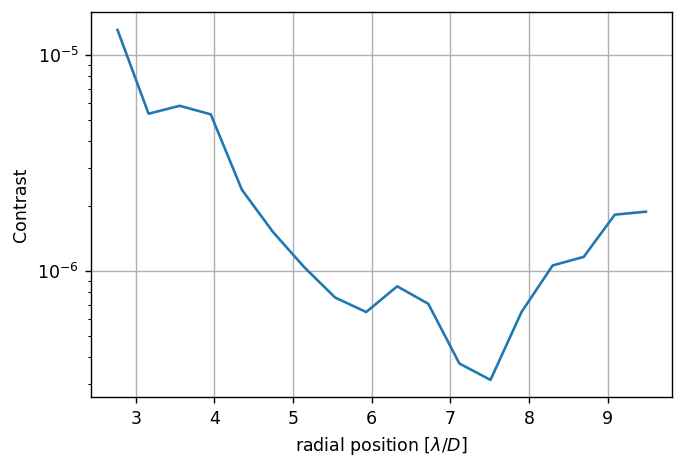

	Closed-loop iteration 8 / 10


(472,)

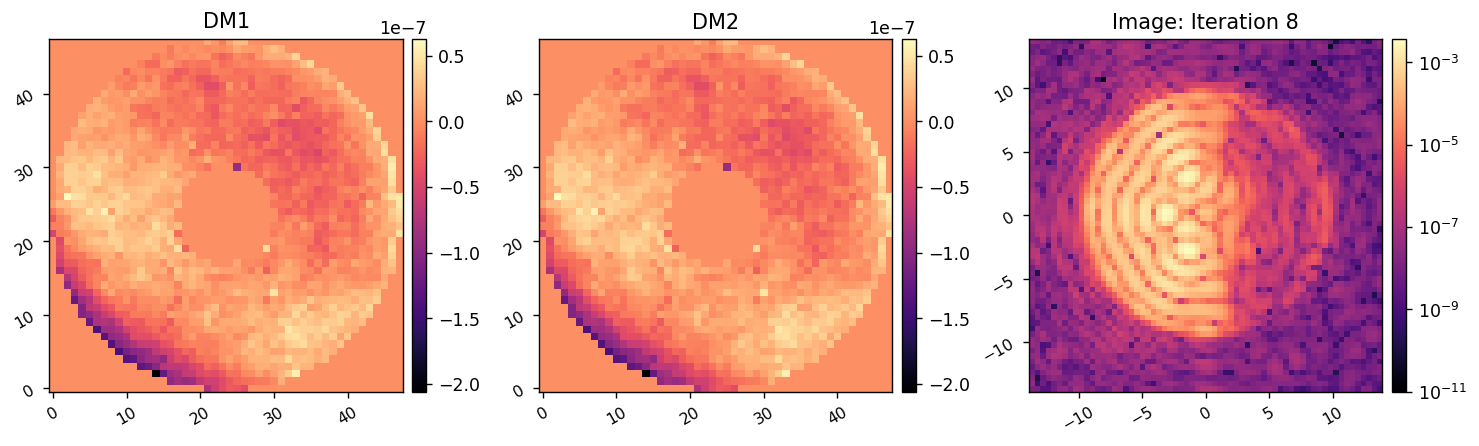

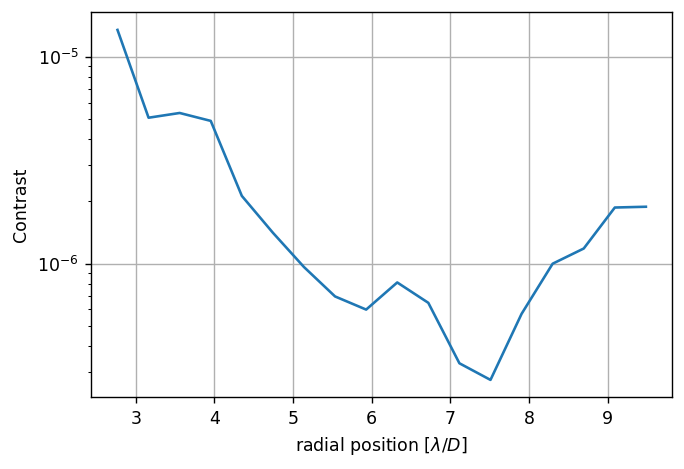

	Closed-loop iteration 9 / 10


(472,)

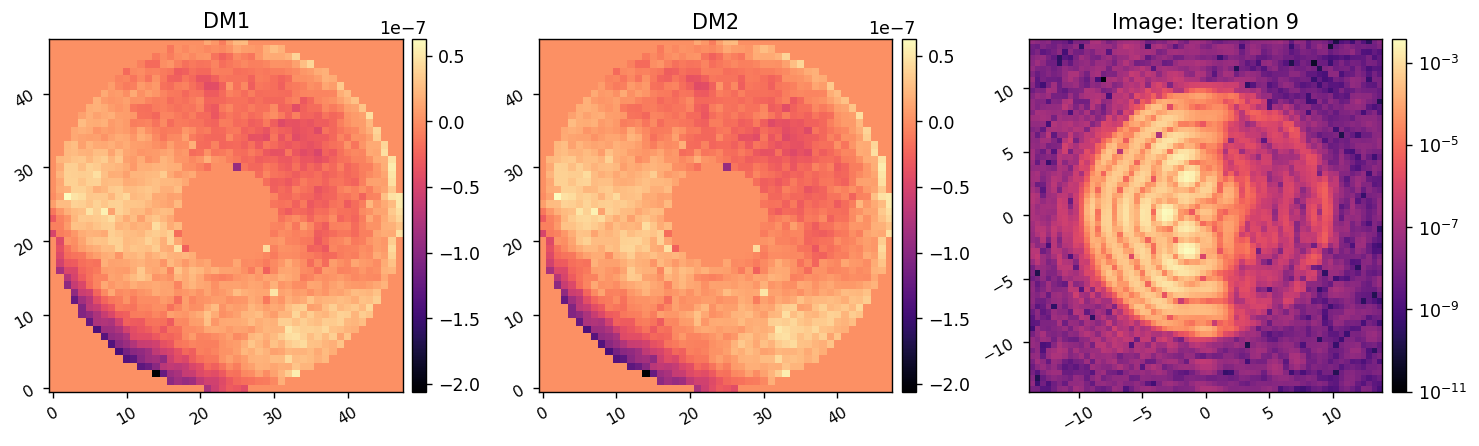

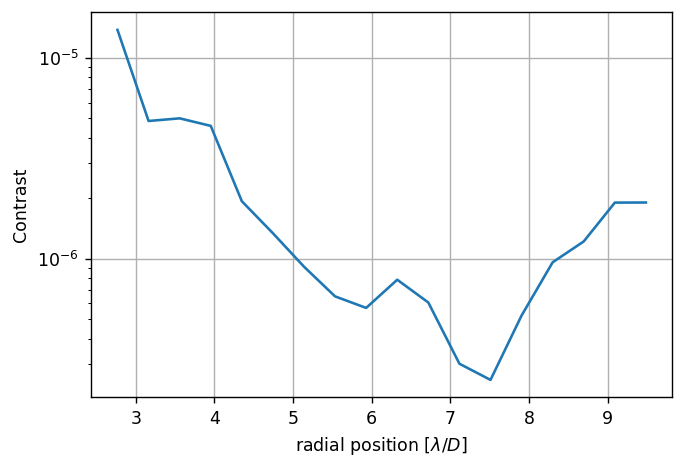

	Closed-loop iteration 10 / 10


(472,)

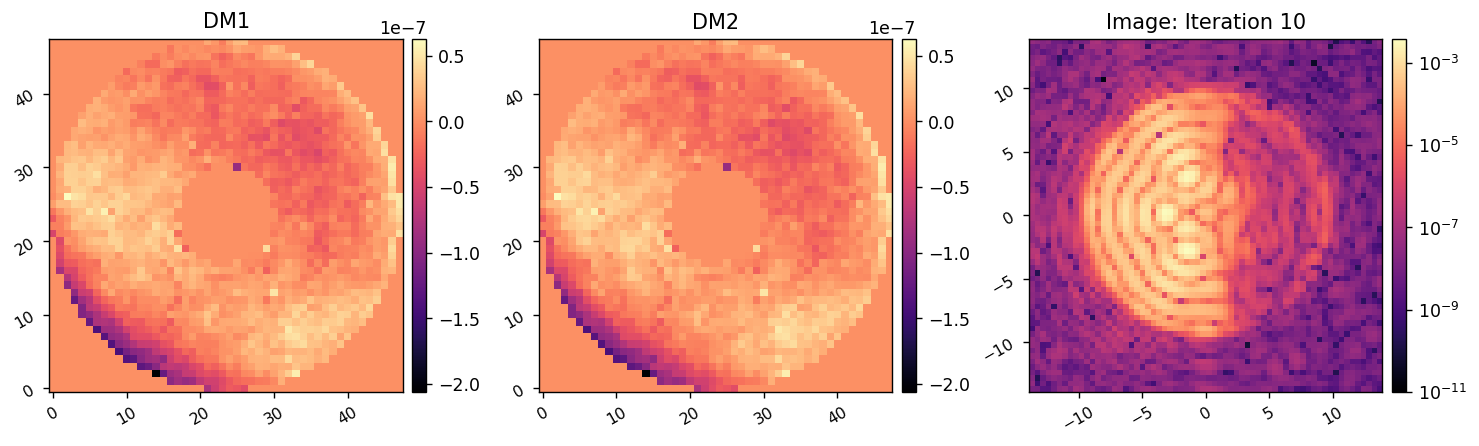

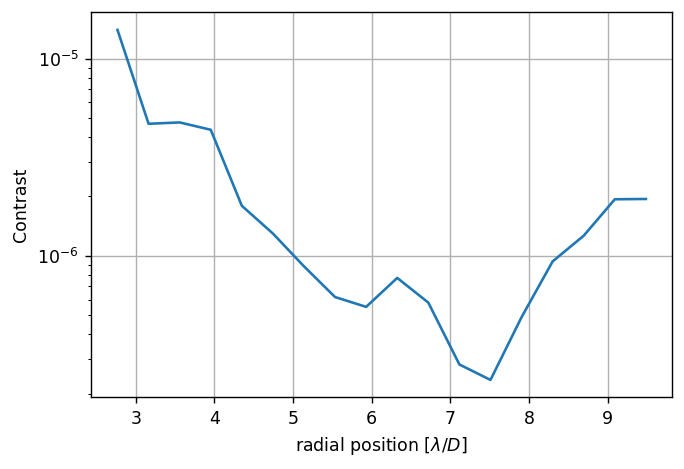

I-EFC loop completed in 22.448s.


In [13]:
reg_cond = 1e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.25, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 472)
Running I-EFC...
	Closed-loop iteration 1 / 10


(472,)

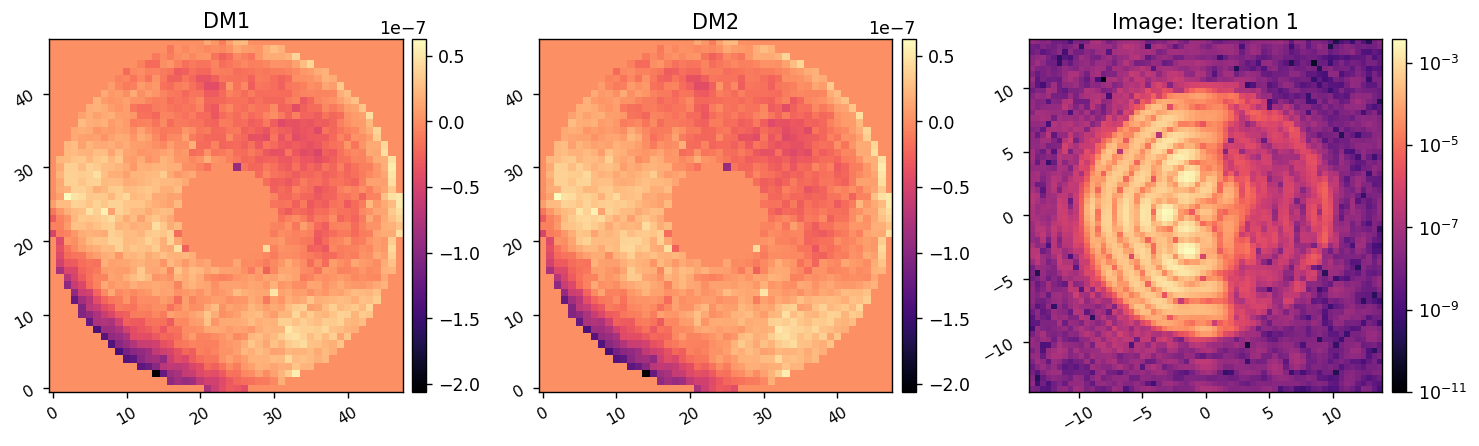

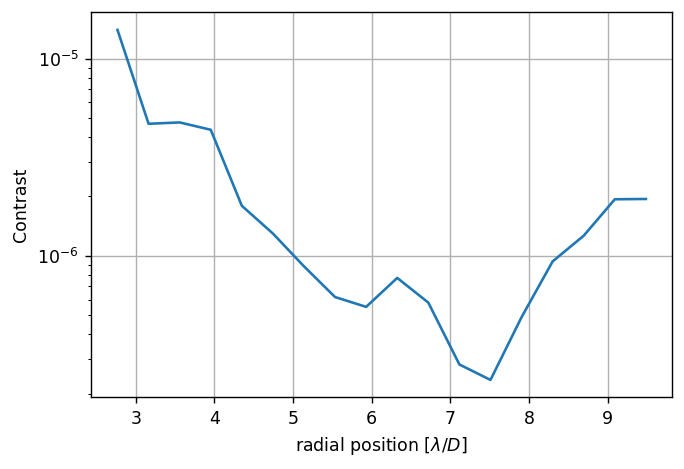

	Closed-loop iteration 2 / 10


(472,)

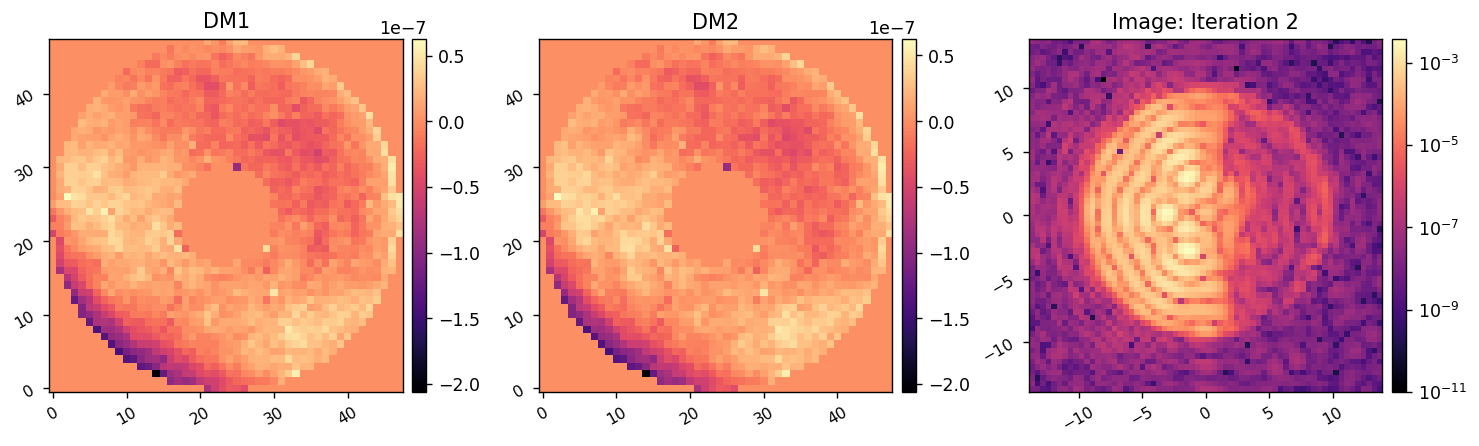

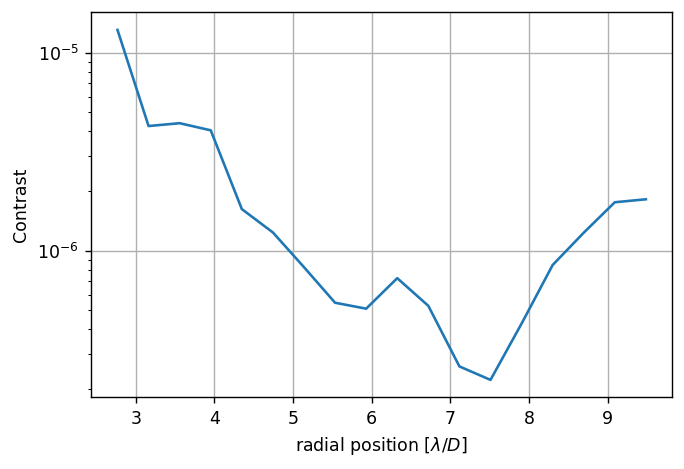

	Closed-loop iteration 3 / 10


(472,)

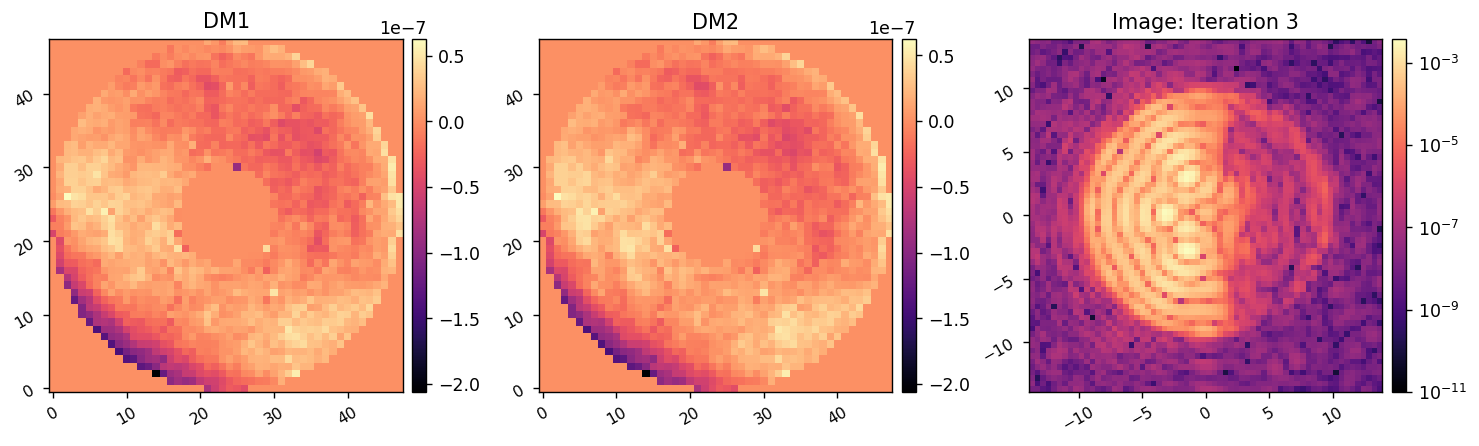

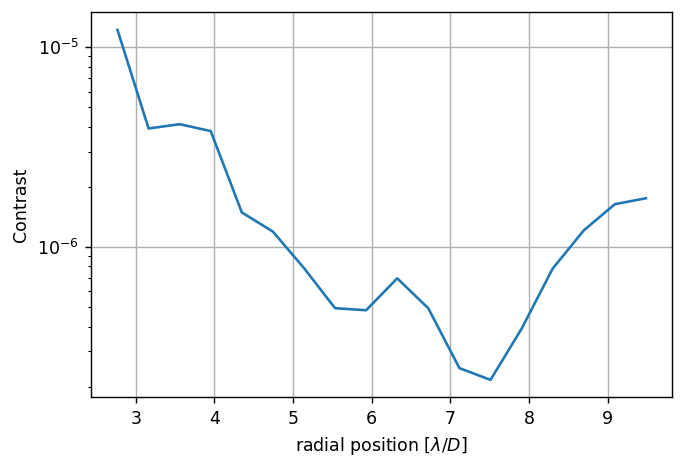

	Closed-loop iteration 4 / 10


(472,)

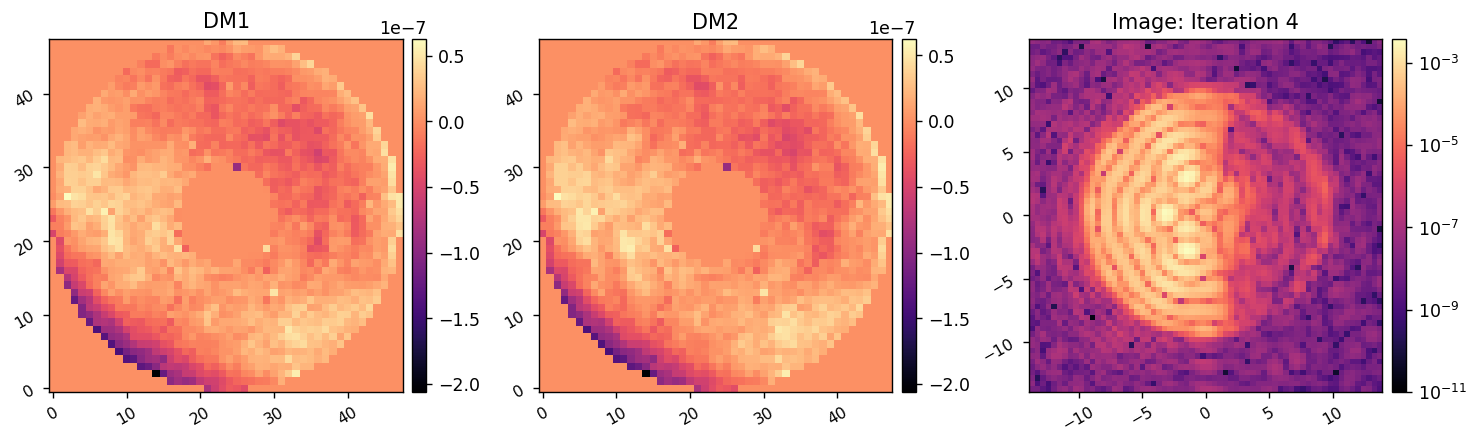

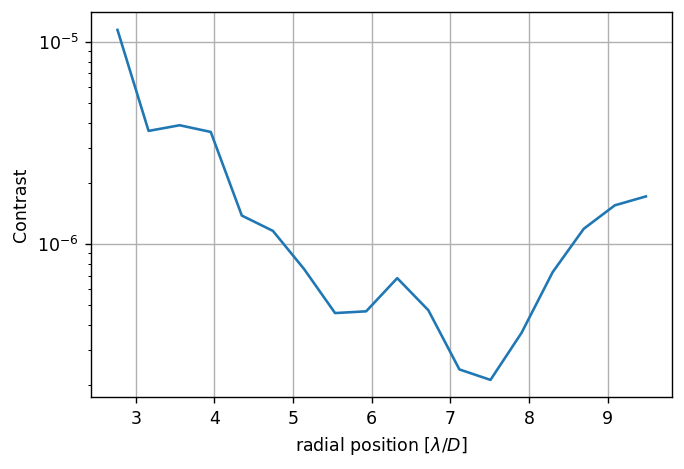

	Closed-loop iteration 5 / 10


(472,)

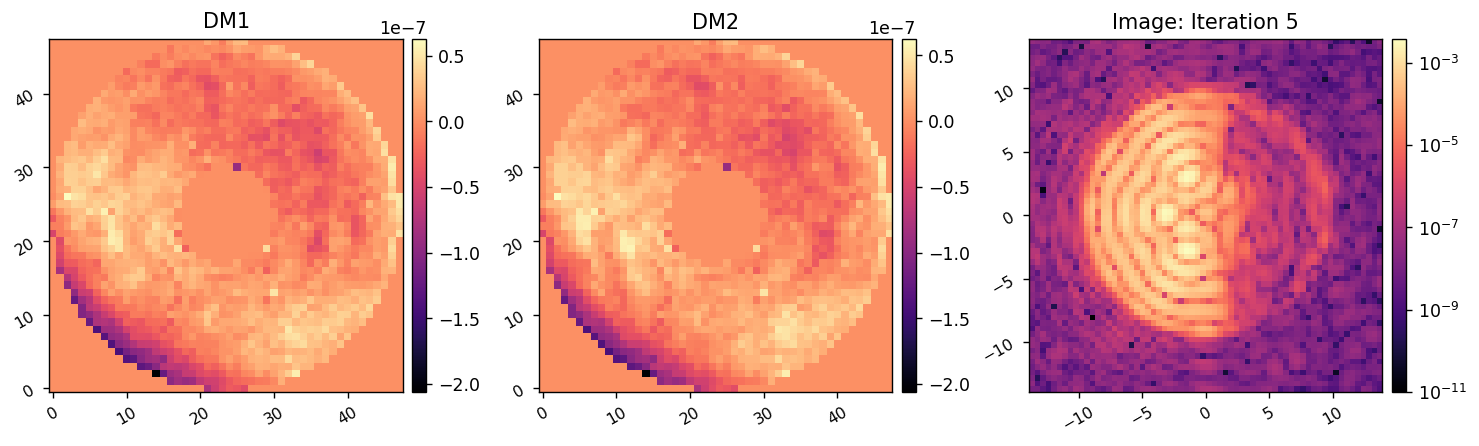

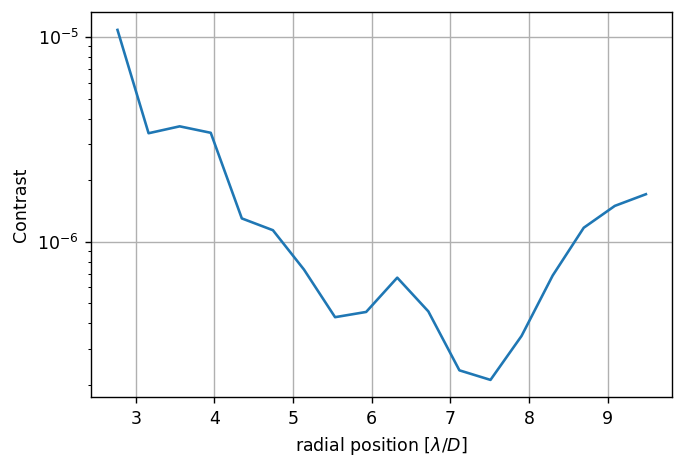

	Closed-loop iteration 6 / 10


(472,)

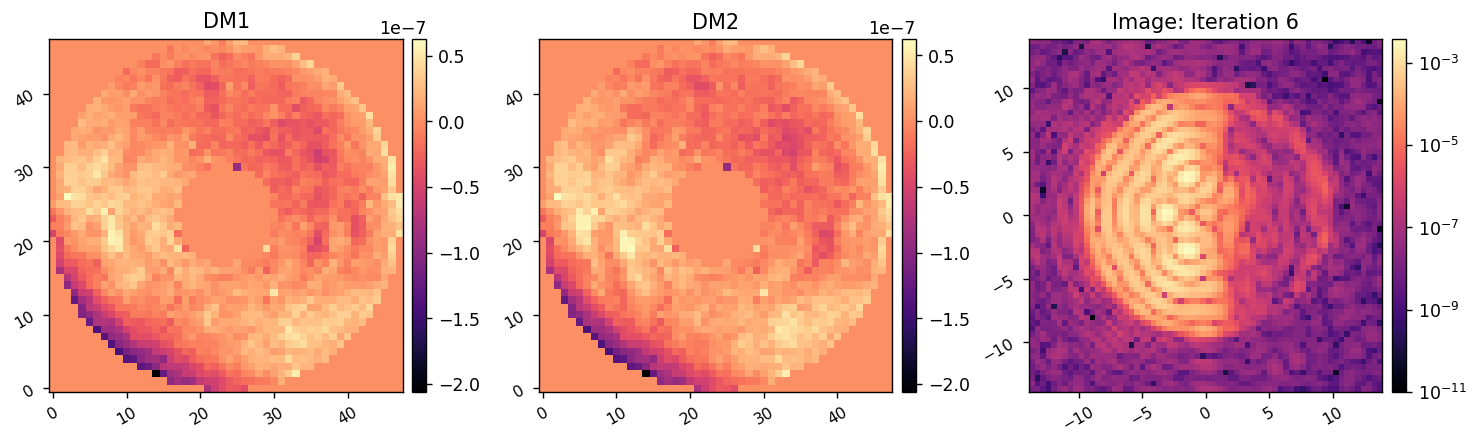

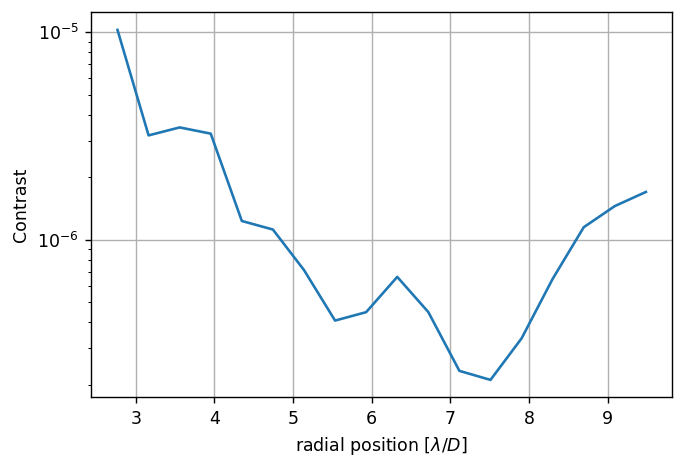

	Closed-loop iteration 7 / 10


(472,)

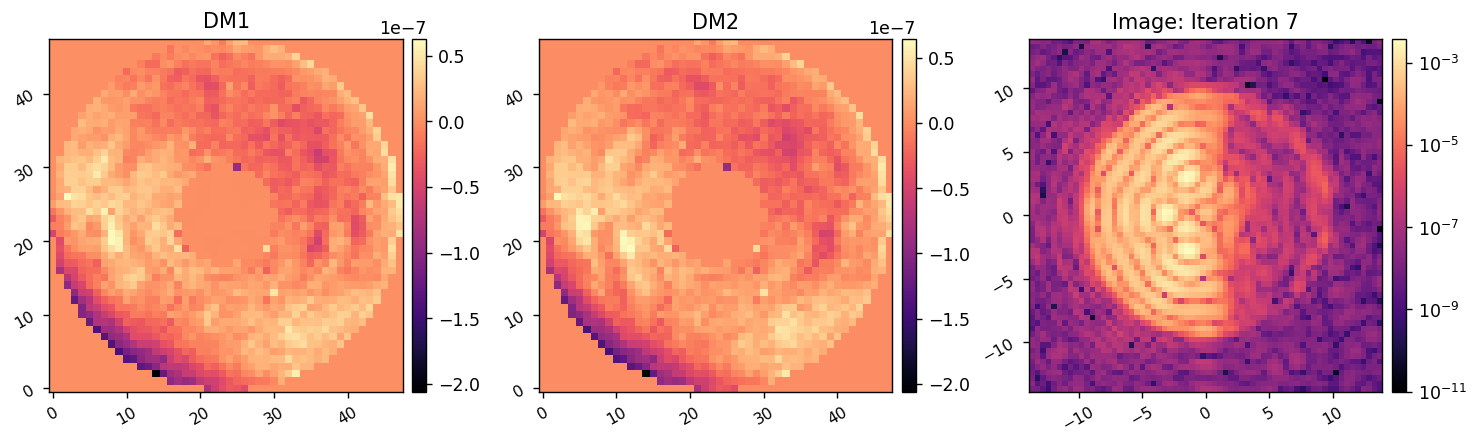

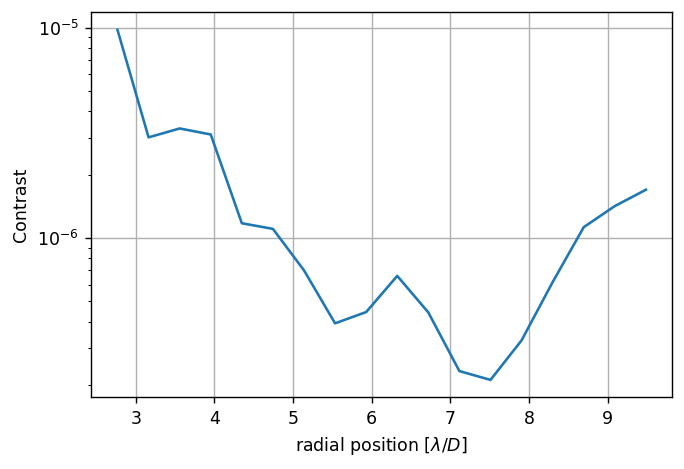

	Closed-loop iteration 8 / 10


(472,)

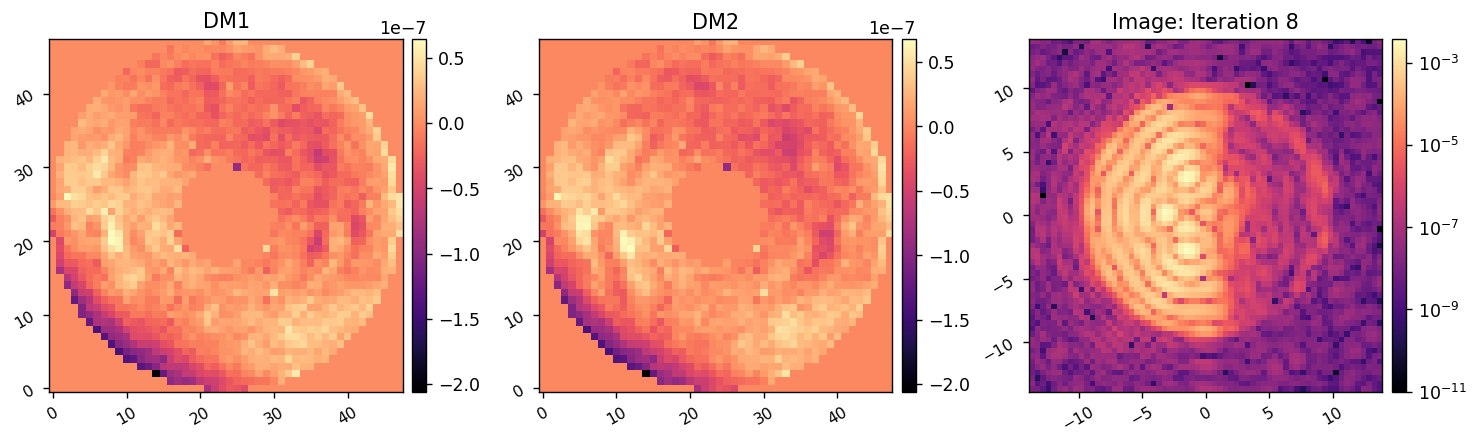

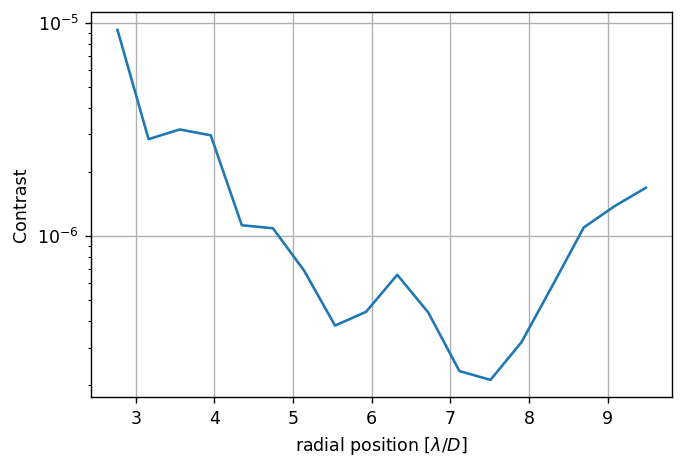

	Closed-loop iteration 9 / 10


(472,)

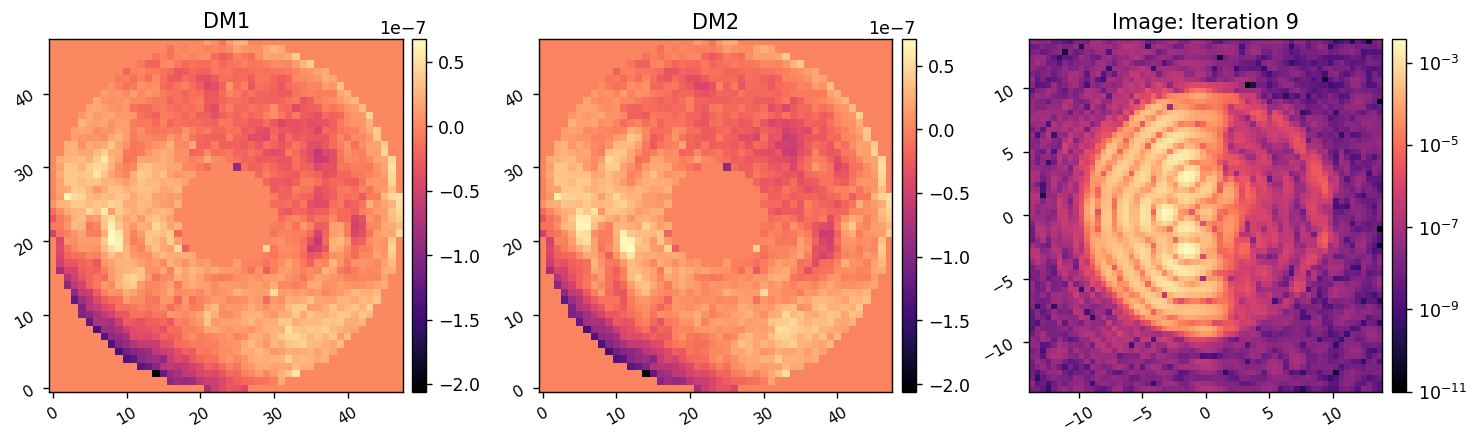

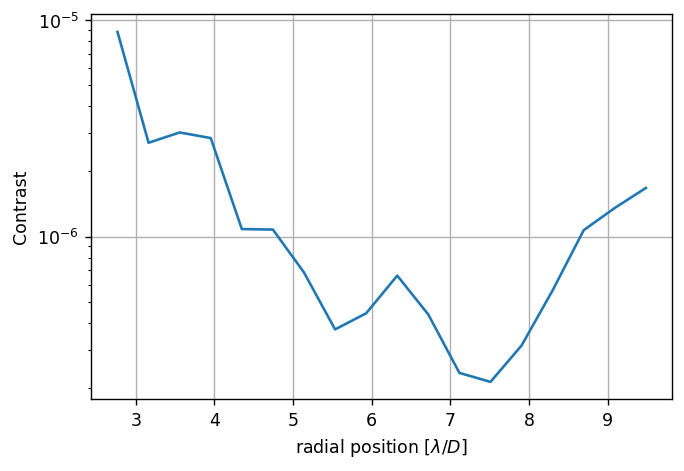

	Closed-loop iteration 10 / 10


(472,)

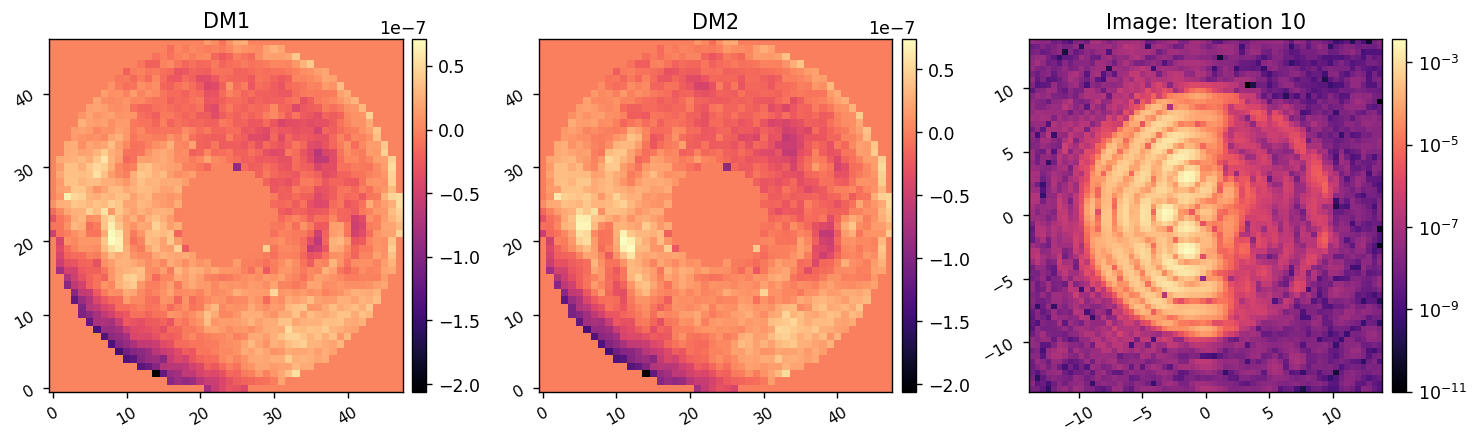

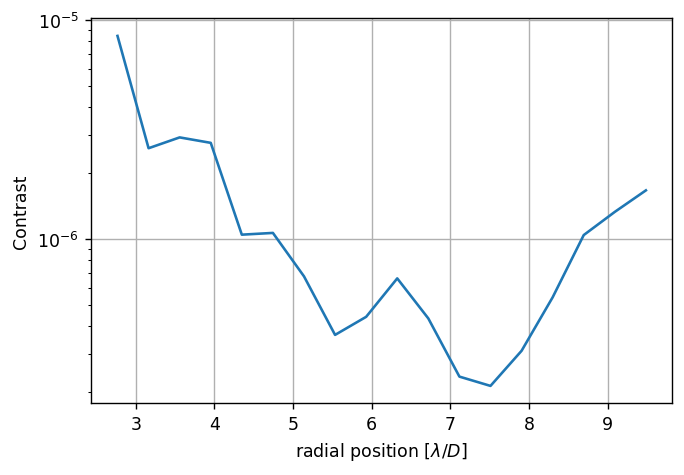

I-EFC loop completed in 23.767s.


In [14]:
reg_cond = 1e-4
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.25, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 472)
Running I-EFC...
	Closed-loop iteration 1 / 5


(472,)

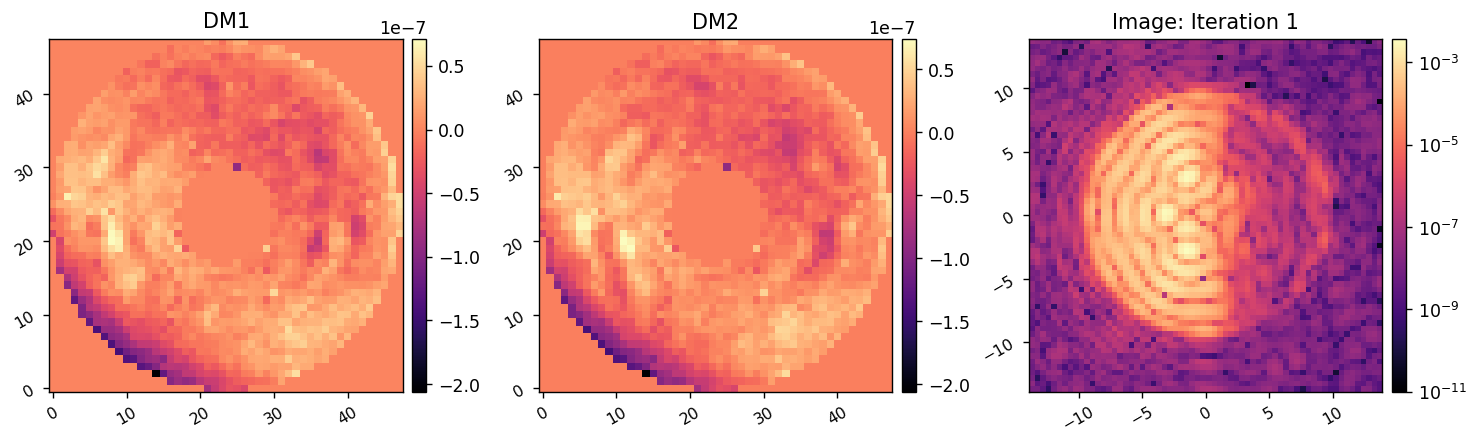

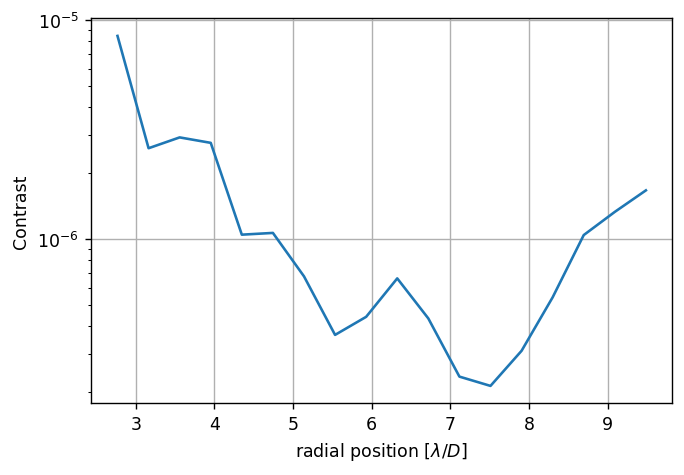

	Closed-loop iteration 2 / 5


(472,)

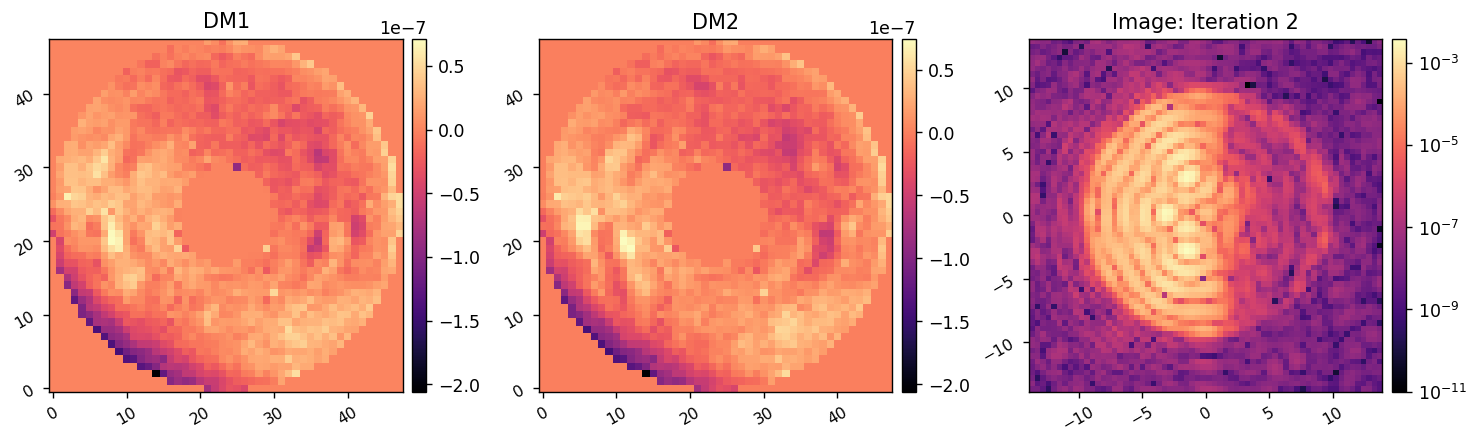

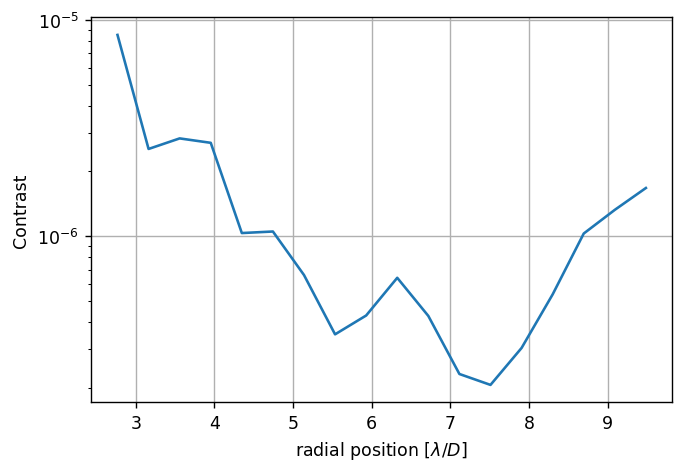

	Closed-loop iteration 3 / 5


(472,)

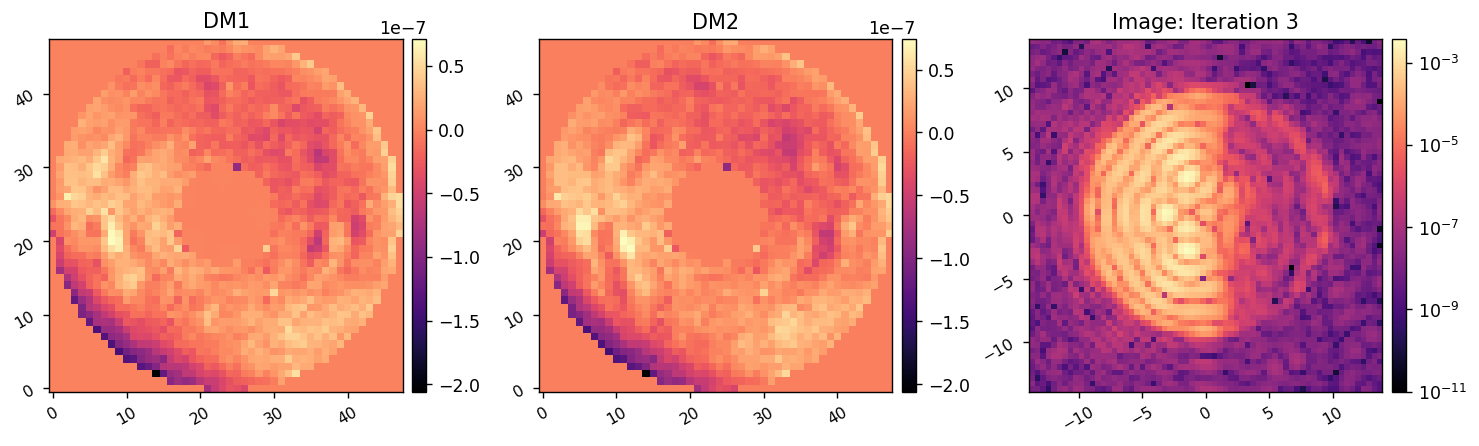

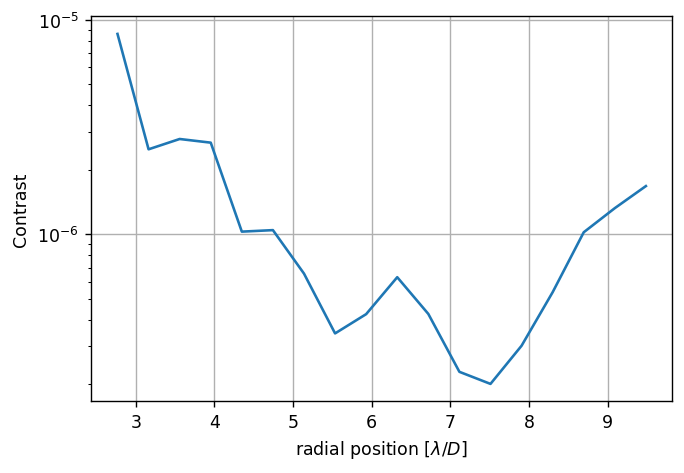

	Closed-loop iteration 4 / 5


(472,)

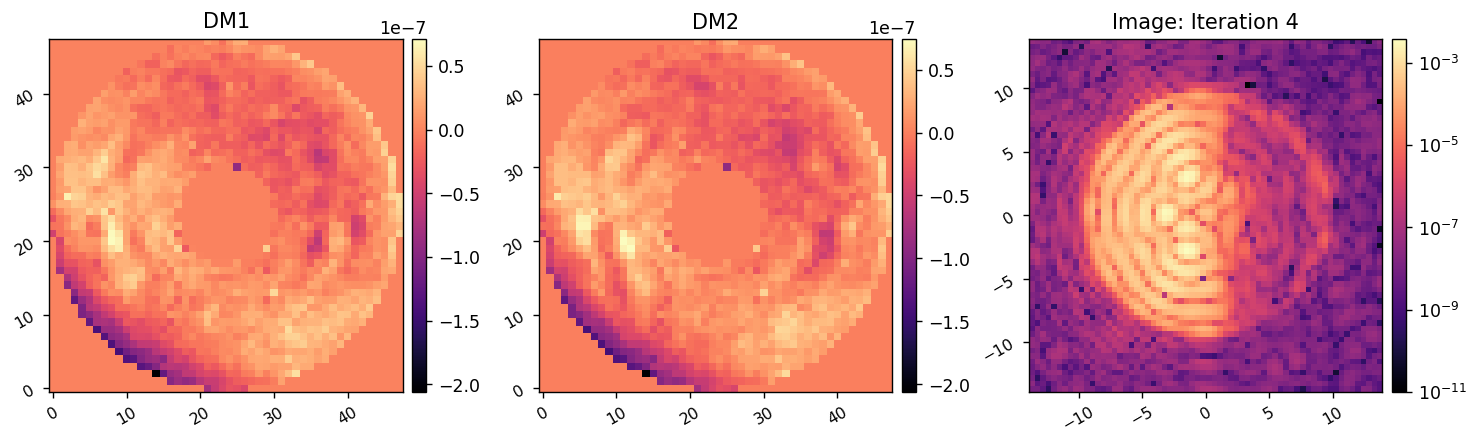

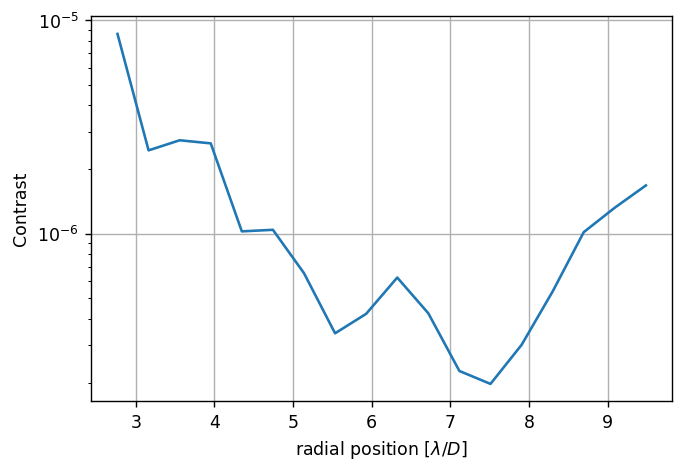

	Closed-loop iteration 5 / 5


(472,)

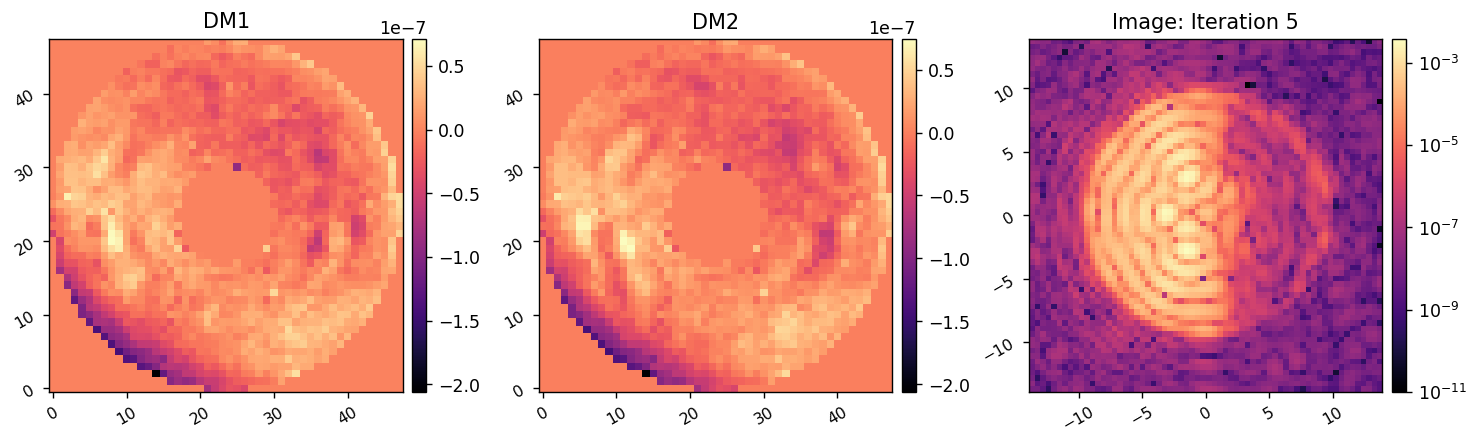

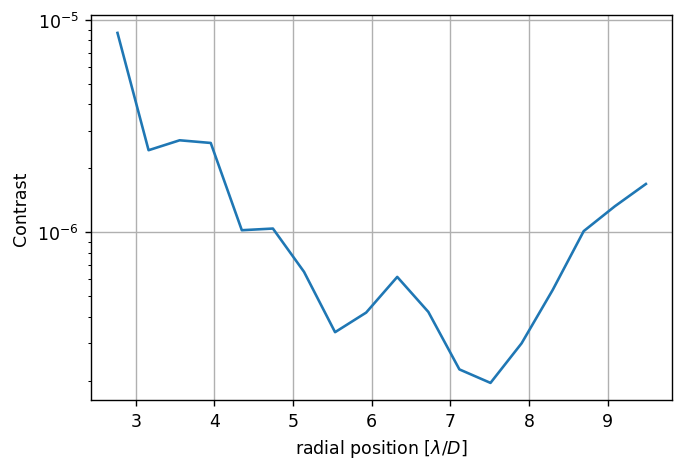

I-EFC loop completed in 11.419s.


In [15]:
reg_cond = 1e-2
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.25, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )

(1108, 1108) (1108, 472)
Running I-EFC...
	Closed-loop iteration 1 / 5


(472,)

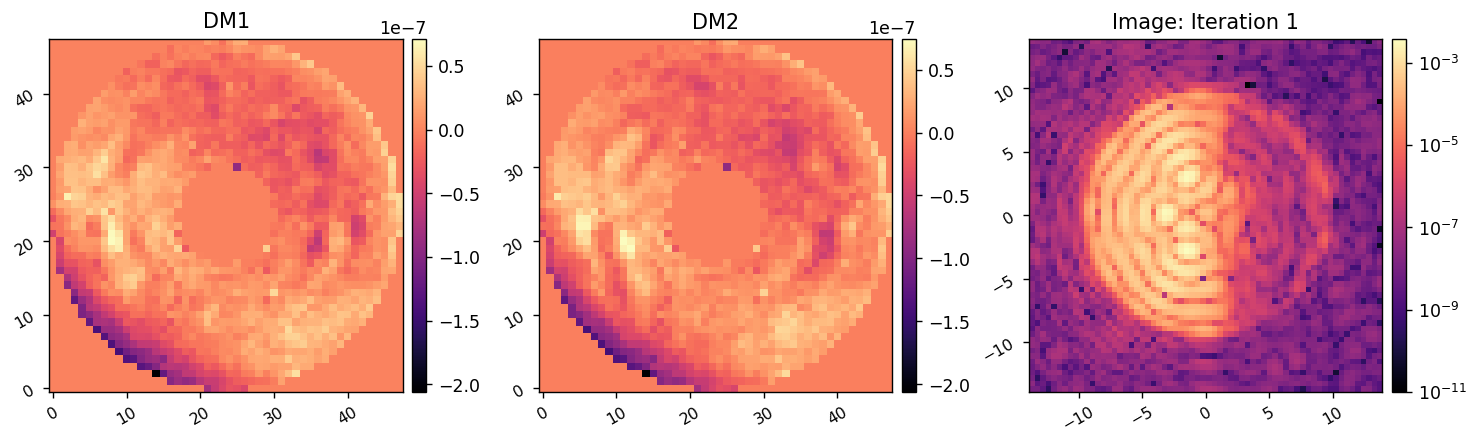

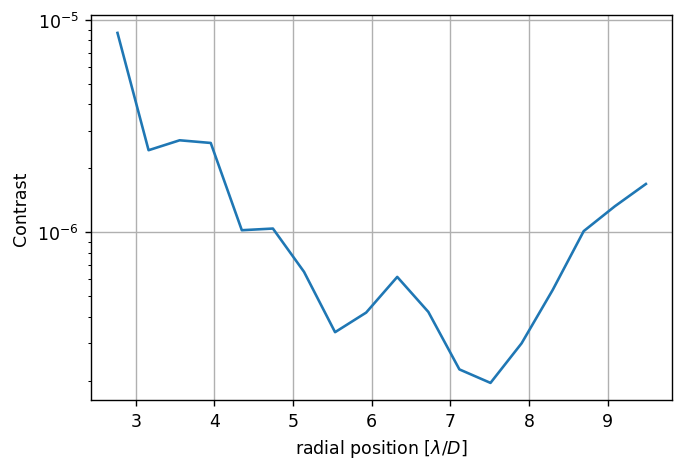

	Closed-loop iteration 2 / 5


(472,)

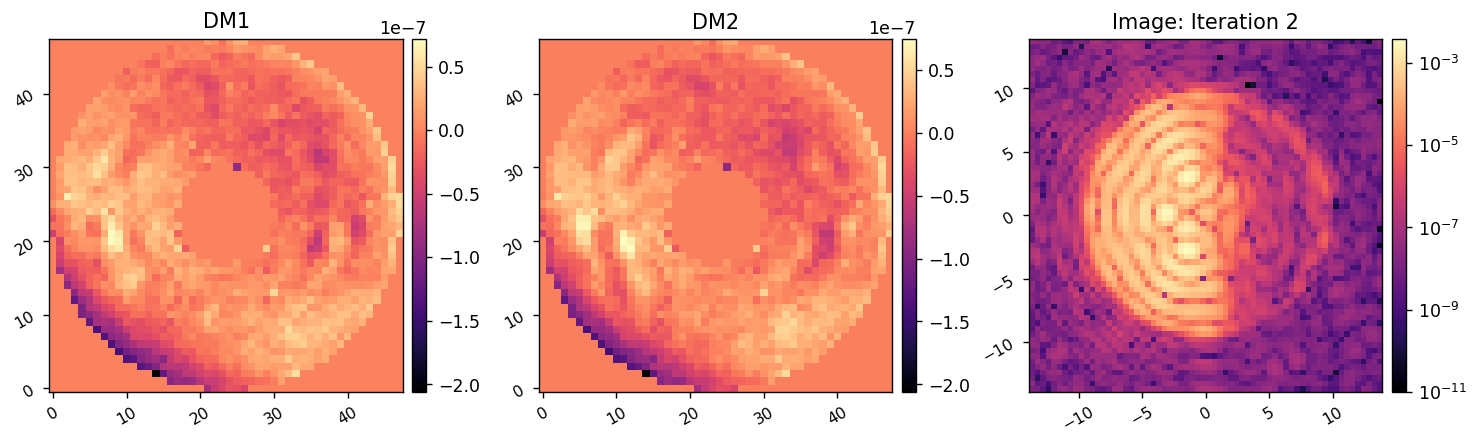

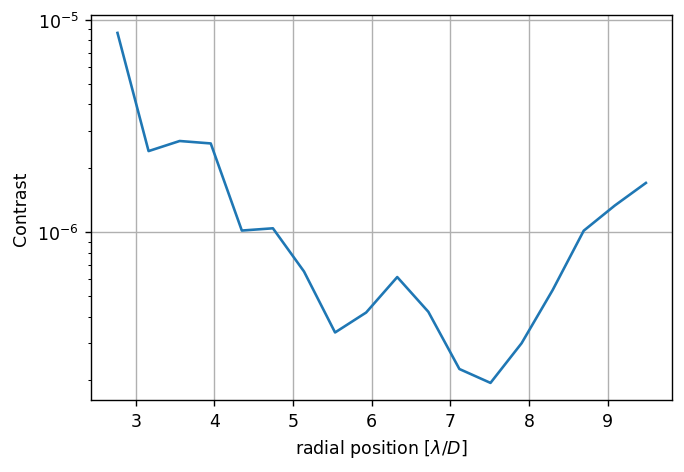

	Closed-loop iteration 3 / 5


(472,)

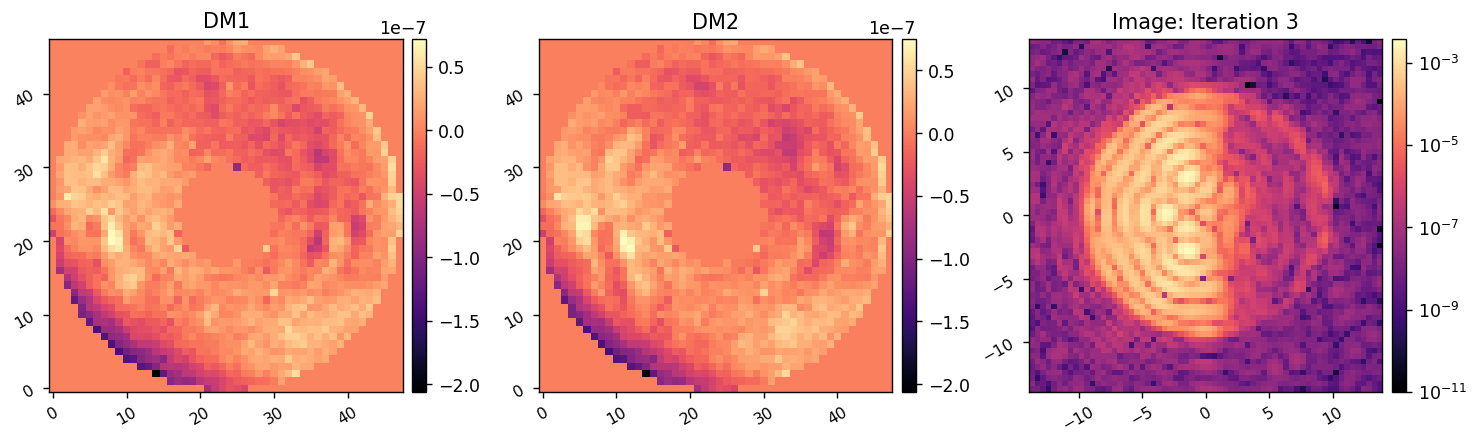

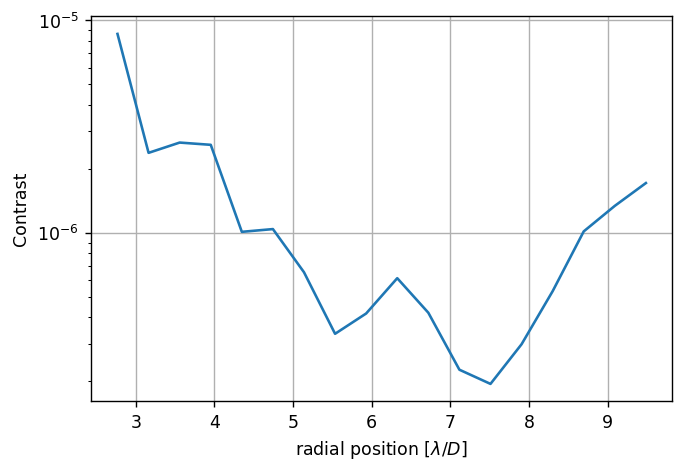

	Closed-loop iteration 4 / 5


(472,)

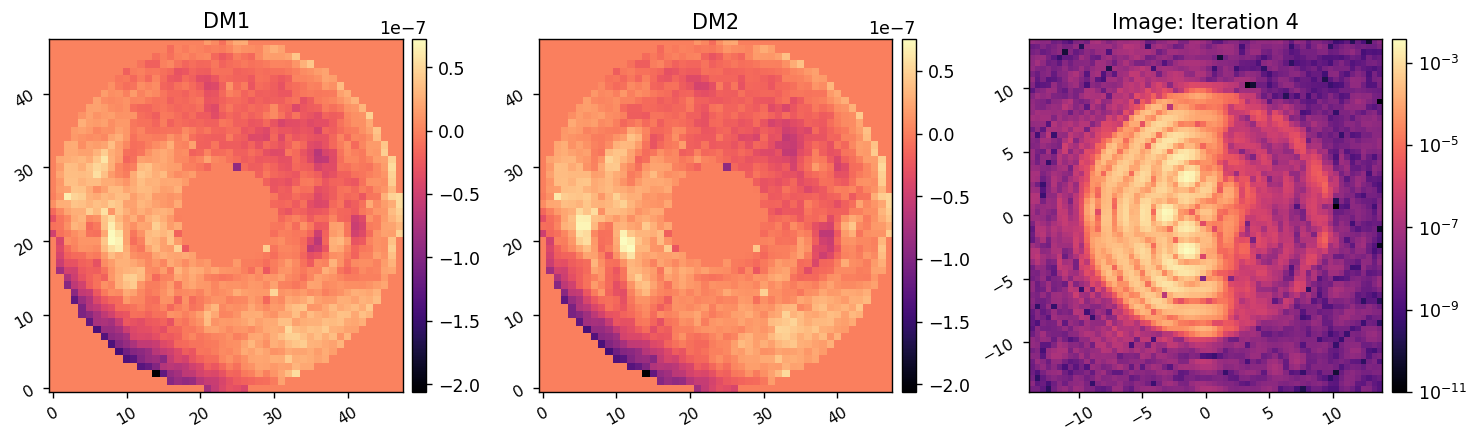

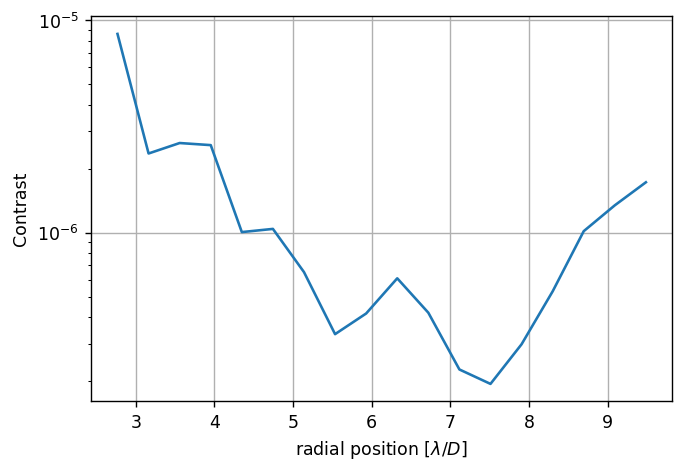

	Closed-loop iteration 5 / 5


(472,)

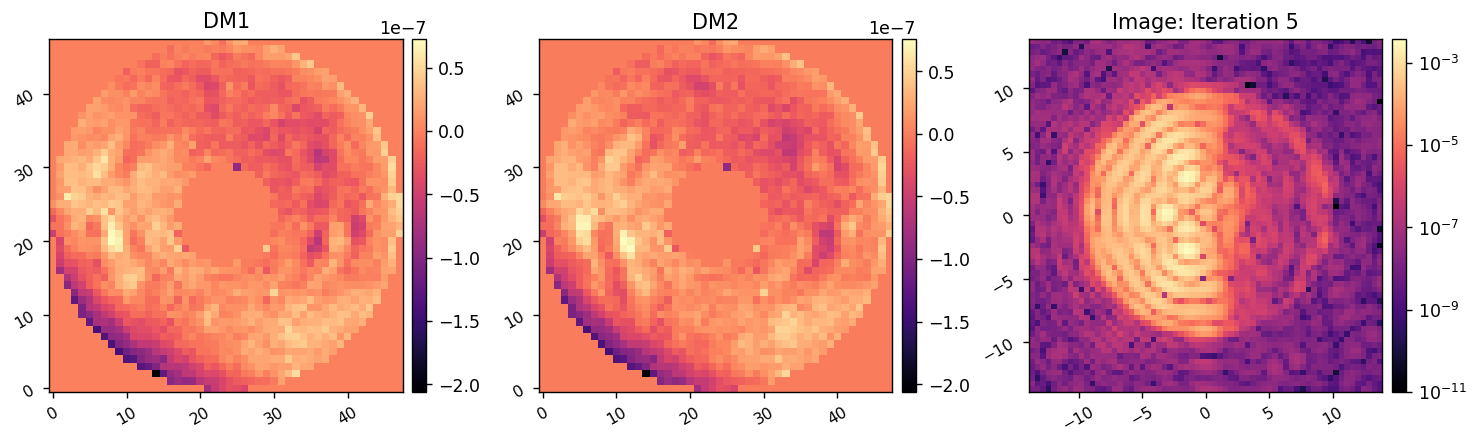

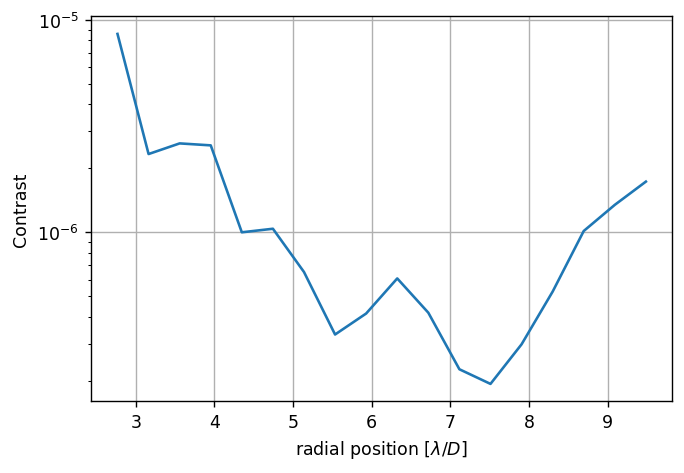

I-EFC loop completed in 11.630s.


In [16]:
reg_cond = 1e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.25, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )

In [17]:
reload(wfsc.iefc_2dm)

response_matrix_2, response_cube_2 = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, ensure_np_array(calib_modes), 
                                                         return_all=True)


Calibrating iEFC...
	Calibrated mode 236/236 in 1301.824s
Calibration complete.


(1108, 1108) (1108, 472)
Running I-EFC...
	Closed-loop iteration 1 / 5


(472,)

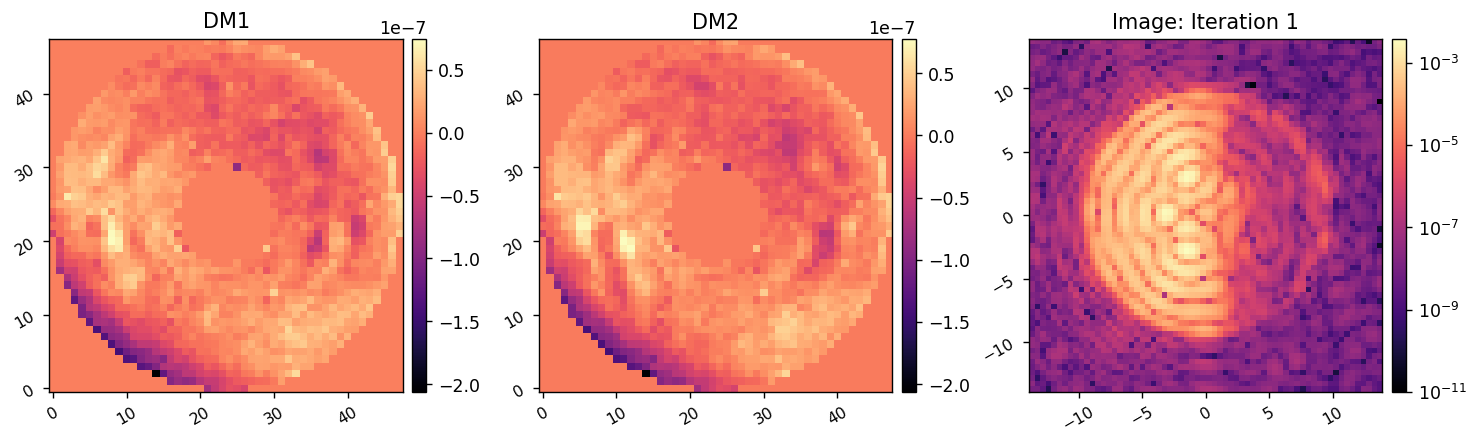

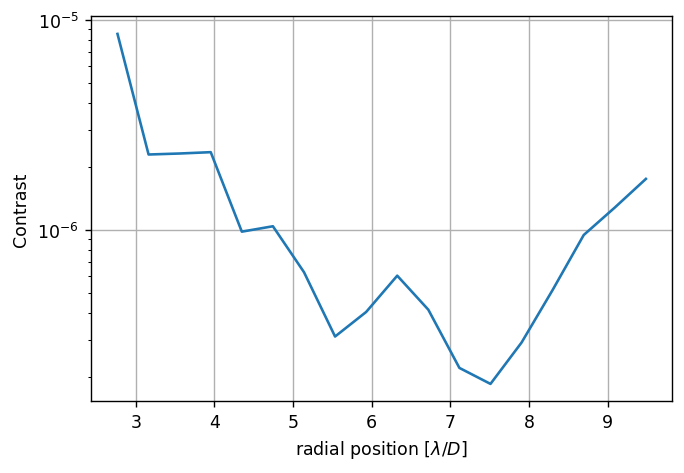

	Closed-loop iteration 2 / 5


(472,)

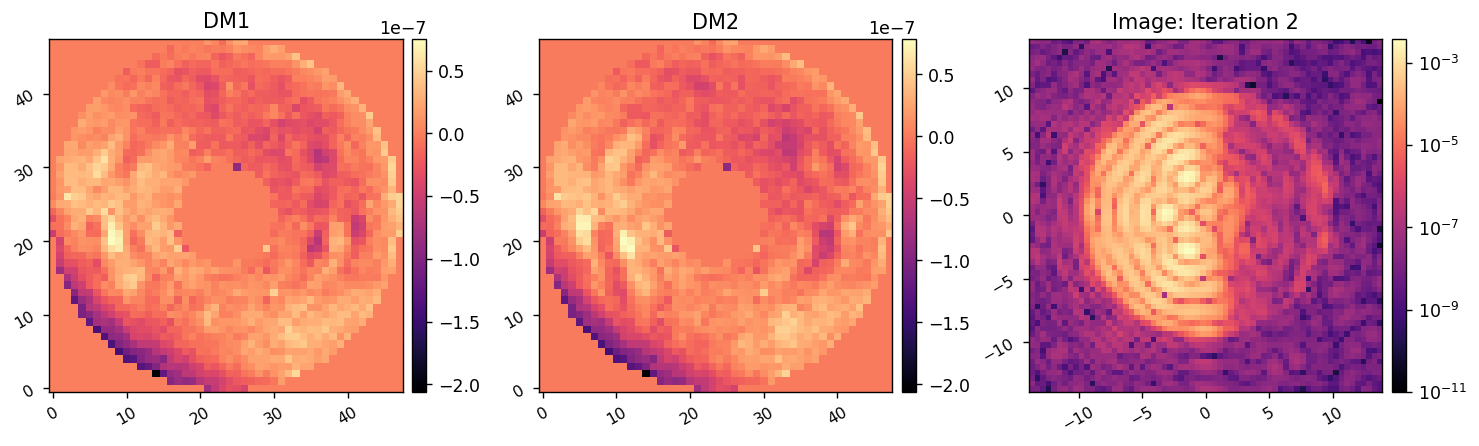

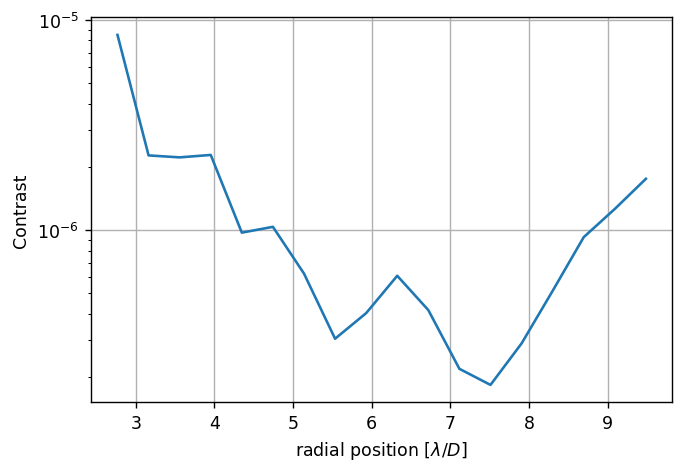

	Closed-loop iteration 3 / 5


(472,)

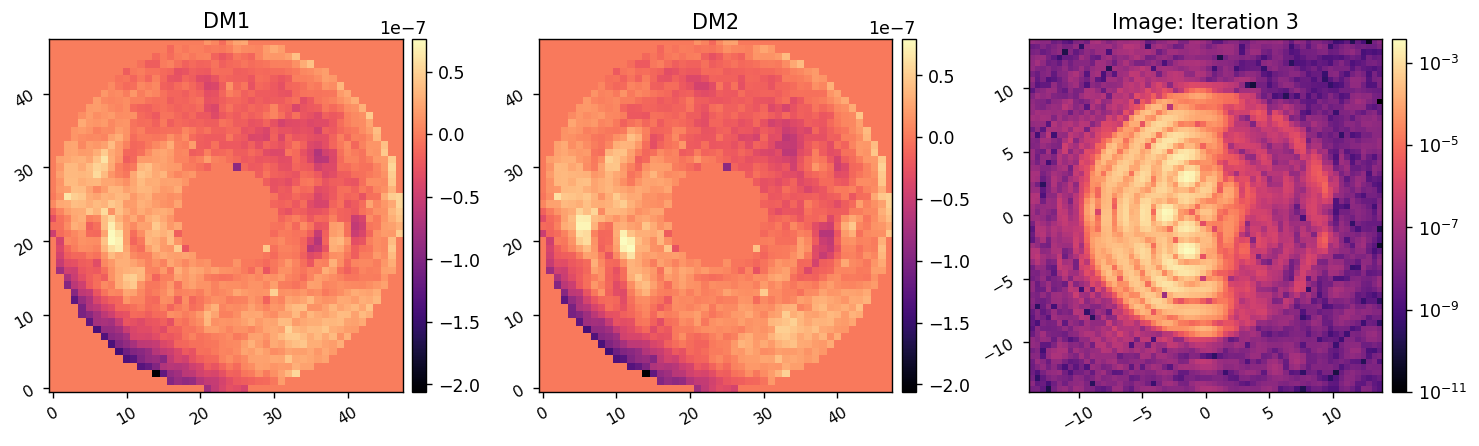

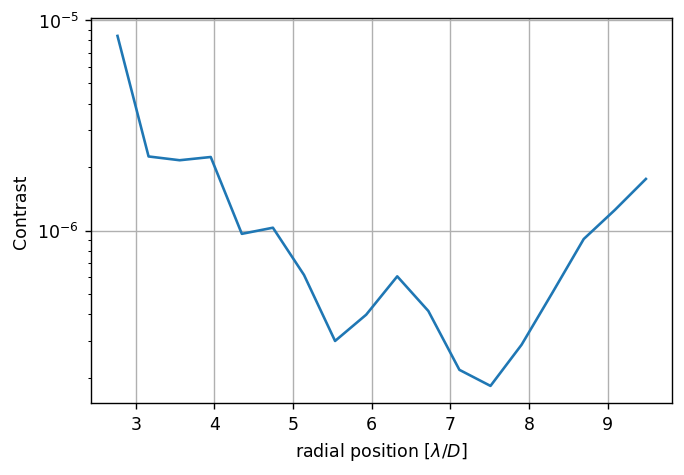

	Closed-loop iteration 4 / 5


(472,)

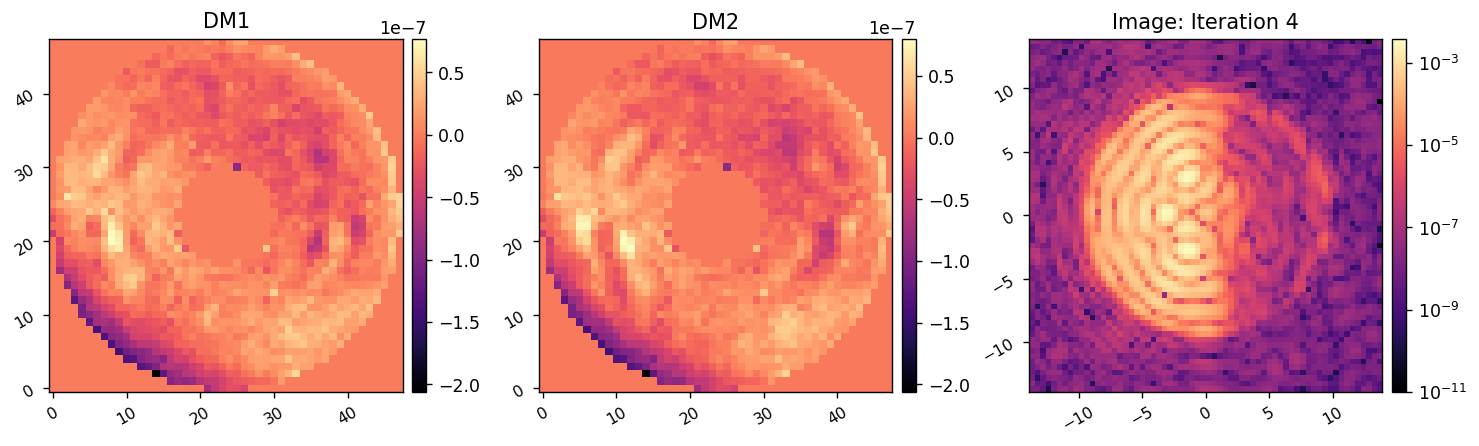

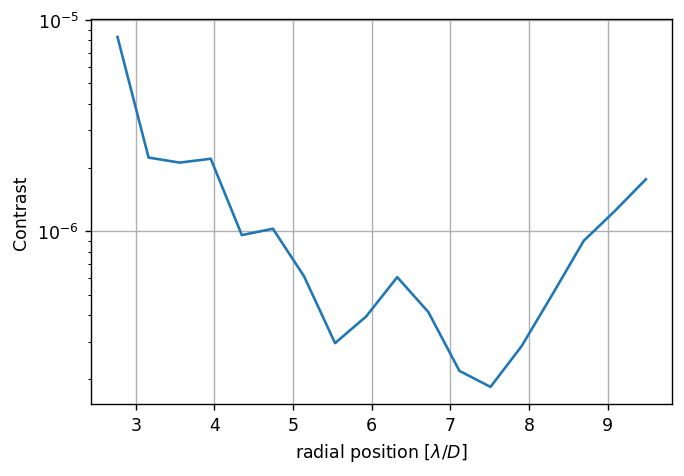

	Closed-loop iteration 5 / 5


(472,)

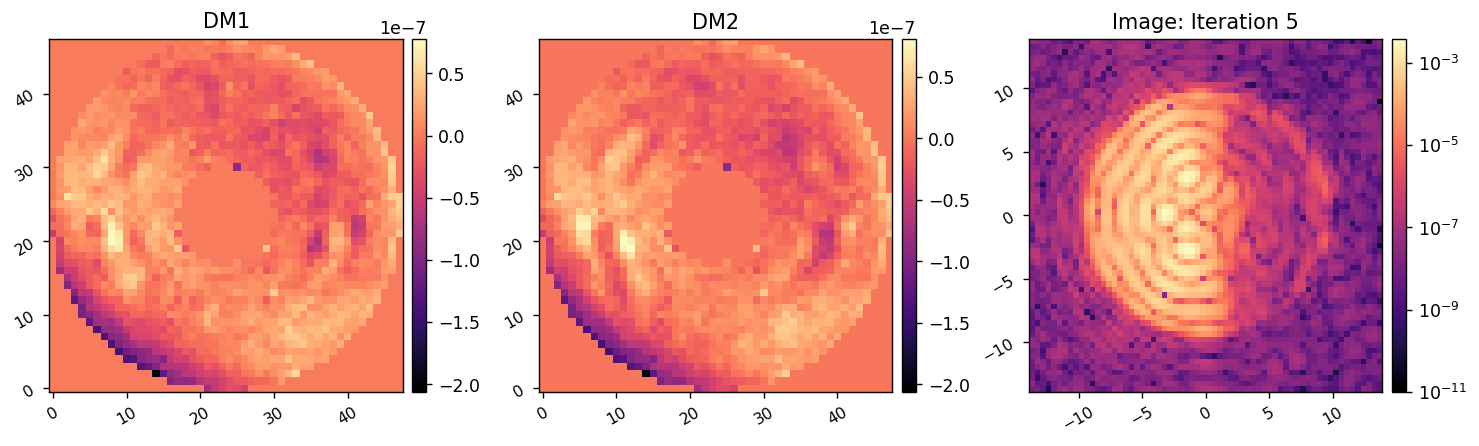

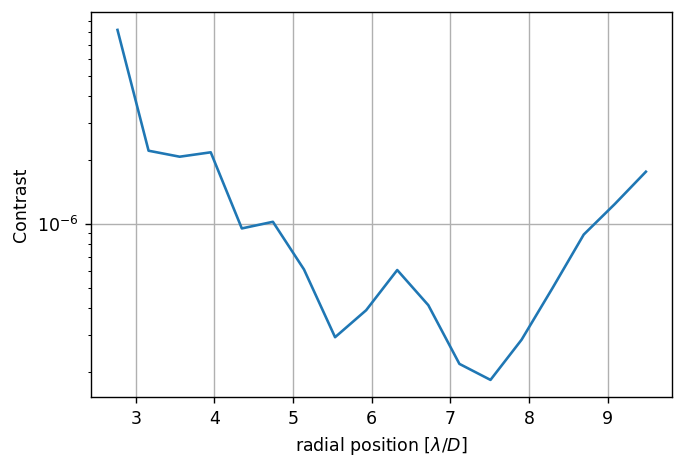

I-EFC loop completed in 11.510s.


In [20]:
reg_cond = 1e-3
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix_2, weight_map, nprobes=len(probe_modes), rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          ensure_np_array(calib_modes),
                                          control_mask, 
                                          num_iterations=5, 
                                          loop_gain=0.55, 
                                          leakage=0.00,
                                          plot_all=True,
                                         )